In [1]:
# upgrade in command line for specific interpreter

import sys
sys.executable
# /Users/lianfeng/Document/species_richness_sdm/venv/bin/pip install --upgrade tensorflow

'/Users/lianfeng/miniconda3/bin/python'

In [2]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


In [12]:
# 
exec('from __future__ import absolute_import, division, print_function, unicode_literals')

import numpy as np
import datetime
import pathlib
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout

In [5]:
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs
    
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorboard.plugins.hparams import api as hp

In [15]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))

pergrid_base = """select distinct * from predictor.pergrid_base"""
pergrid_base_df = pd.read_sql(pergrid_base, engine)
pergrid_base_df_na_remove = pergrid_base_df.dropna()

pergrid_expanded_encoded=pd.get_dummies(pergrid_base_df_na_remove, columns=["shg"])

pred_var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
   'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
   'mtwq','shg_A', 'shg_A/D', 'shg_B', 'shg_B/D', 'shg_C', 'shg_C/D', 'shg_D']

grid_id = pergrid_base_df_na_remove['grid_id']
y = np.asarray(pergrid_base_df_na_remove['tsr'])
x = np.asarray(pergrid_expanded_encoded[pred_var])

In [7]:
def data():
    localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
    params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
    engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
    
    pergrid_base = """select distinct * from predictor.pergrid_base"""
    pergrid_base_df = pd.read_sql(pergrid_base, engine)
    pergrid_base_df_na_remove = pergrid_base_df.dropna()

    pergrid_expanded_encoded=pd.get_dummies(pergrid_base_df_na_remove, columns=["shg"])

    pred_var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt',
       'mtwq','shg_A', 'shg_A/D', 'shg_B', 'shg_B/D', 'shg_C', 'shg_C/D', 'shg_D']

    grid_id = pergrid_base_df_na_remove['grid_id']
    y = pergrid_base_df_na_remove['tsr']
    x = pergrid_expanded_encoded[pred_var]

    # normalize features 
    x_stats = x.describe()
    x_stats = x_stats.transpose()
    x = (x - x_stats['mean']) / x_stats['std']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12345)
    # return x_train.to_numpy(), x_val.to_numpy(), x_test.to_numpy(), y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()
    return np.asarray(x_train), np.asarray(x_val), np.asarray(x_test), np.asarray(y_train), np.asarray(y_val), np.asarray(y_test)

In [22]:
def create_model(x_train, y_train, x_val, y_val):

    model = keras.Sequential()
    model.add(layers.Dense({{choice([128, 256, 512, 1024])}}, input_shape=(x_train.shape[1],)))  # tune # of units
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))  # tune the activation function
    model.add(Dropout({{uniform(0, 1)}}))  # tune dropout rate

    model.add(Dense({{choice([128, 256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # tune # of layers
    if {{choice(['two', 'three'])}} == 'three':
        model.add(Dense({{choice([128, 256, 512, 1024])}}))
        model.add(Activation({{choice(['relu', 'sigmoid'])}}))
        model.add(Dropout({{uniform(0, 1)}}))

    model.add(Dense(1))
    model.add(Activation('linear'))

    # tune the optimizer and the learning rate
    adam = keras.optimizers.Adam(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})
    rmsprop = keras.optimizers.RMSprop(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})
    sgd = keras.optimizers.SGD(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})

    choiceval = {{choice(['adam', 'sgd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd

    model.compile(loss='mae', metrics=['mean_squared_error'], optimizer=optim)
    result=model.fit(x_train, y_train,
              batch_size={{choice([128, 256, 512])}},
              nb_epoch=1000,
              verbose=2,
              validation_data=(x_val, y_val))
    
    mae, mse = model.evaluate(x_val, y_val, verbose=0)
    print('MSE:', mse)
    return {'loss': mae, 'status': STATUS_OK, 'model': model}

In [ ]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=30,
                                      trials=Trials(),
                                      notebook_name='M5_FNN')

>>> Imports:
#coding=utf-8

try:
    import sys
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
    from hyperas.distributions import choice, uniform
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import datetime
except:
    pass

try:
    import pathlib
except:
    pass

try:
    from sqlalchemy import create_engine
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn import preprocessing
except:
    pass

try:
    from tensorflow import keras
except:
    pass

try:
    from tensorflow.keras import layers
except:
    pass

try:
    from tensorflow.keras.layers import Dense, Activation, Dropout
except:
    pass

try:
    import tensorflow_docs a

8641/8641 - 1s - loss: 4.0721 - mean_squared_error: 32.3144 - val_loss: 3.4421 - val_mean_squared_error: 23.0322

Epoch 15/1000                                         
8641/8641 - 1s - loss: 4.0725 - mean_squared_error: 31.6681 - val_loss: 3.4407 - val_mean_squared_error: 23.1883

Epoch 16/1000                                         
8641/8641 - 1s - loss: 3.9809 - mean_squared_error: 31.2724 - val_loss: 4.0094 - val_mean_squared_error: 29.3773

Epoch 17/1000                                         
8641/8641 - 1s - loss: 4.0289 - mean_squared_error: 31.0722 - val_loss: 3.4636 - val_mean_squared_error: 23.3350

Epoch 18/1000                                         
8641/8641 - 1s - loss: 3.9816 - mean_squared_error: 30.6452 - val_loss: 3.7091 - val_mean_squared_error: 25.0124

Epoch 19/1000                                         
8641/8641 - 1s - loss: 3.9938 - mean_squared_error: 30.9079 - val_loss: 3.3970 - val_mean_squared_error: 22.3332

Epoch 20/1000                            

Epoch 63/1000                                         
8641/8641 - 1s - loss: 3.4666 - mean_squared_error: 23.9728 - val_loss: 3.1980 - val_mean_squared_error: 19.9115

Epoch 64/1000                                         
8641/8641 - 1s - loss: 3.5478 - mean_squared_error: 24.9782 - val_loss: 3.5259 - val_mean_squared_error: 24.6312

Epoch 65/1000                                         
8641/8641 - 1s - loss: 3.4219 - mean_squared_error: 23.1891 - val_loss: 3.5174 - val_mean_squared_error: 24.3324

Epoch 66/1000                                         
8641/8641 - 1s - loss: 3.4623 - mean_squared_error: 23.6548 - val_loss: 3.3773 - val_mean_squared_error: 22.8587

Epoch 67/1000                                         
8641/8641 - 1s - loss: 3.5166 - mean_squared_error: 24.9374 - val_loss: 3.3495 - val_mean_squared_error: 21.9806

Epoch 68/1000                                         
8641/8641 - 1s - loss: 3.4388 - mean_squared_error: 23.6718 - val_loss: 3.6596 - val_mean_squared_er

8641/8641 - 1s - loss: 3.3564 - mean_squared_error: 22.5834 - val_loss: 3.1428 - val_mean_squared_error: 19.3327

Epoch 112/1000                                        
8641/8641 - 1s - loss: 3.3598 - mean_squared_error: 22.7388 - val_loss: 3.2851 - val_mean_squared_error: 21.2757

Epoch 113/1000                                        
8641/8641 - 1s - loss: 3.3574 - mean_squared_error: 22.5040 - val_loss: 3.3468 - val_mean_squared_error: 21.7896

Epoch 114/1000                                        
8641/8641 - 1s - loss: 3.3427 - mean_squared_error: 22.2784 - val_loss: 3.9531 - val_mean_squared_error: 30.2563

Epoch 115/1000                                        
8641/8641 - 1s - loss: 3.3413 - mean_squared_error: 22.5829 - val_loss: 3.2779 - val_mean_squared_error: 21.3058

Epoch 116/1000                                        
8641/8641 - 1s - loss: 3.3239 - mean_squared_error: 22.1373 - val_loss: 3.6322 - val_mean_squared_error: 25.7035

Epoch 117/1000                           

Epoch 160/1000                                        
8641/8641 - 1s - loss: 3.2435 - mean_squared_error: 21.4715 - val_loss: 3.3096 - val_mean_squared_error: 21.9772

Epoch 161/1000                                        
8641/8641 - 1s - loss: 3.1904 - mean_squared_error: 20.5638 - val_loss: 3.2733 - val_mean_squared_error: 21.3338

Epoch 162/1000                                        
8641/8641 - 1s - loss: 3.2731 - mean_squared_error: 21.6429 - val_loss: 3.6273 - val_mean_squared_error: 26.4775

Epoch 163/1000                                        
8641/8641 - 1s - loss: 3.1864 - mean_squared_error: 20.6632 - val_loss: 3.2563 - val_mean_squared_error: 20.9525

Epoch 164/1000                                        
8641/8641 - 1s - loss: 3.2925 - mean_squared_error: 21.8001 - val_loss: 3.7356 - val_mean_squared_error: 27.0235

Epoch 165/1000                                        
8641/8641 - 1s - loss: 3.2201 - mean_squared_error: 21.0723 - val_loss: 3.2606 - val_mean_squared_er

8641/8641 - 1s - loss: 3.1566 - mean_squared_error: 20.1724 - val_loss: 3.2991 - val_mean_squared_error: 20.7819

Epoch 209/1000                                        
8641/8641 - 1s - loss: 3.1172 - mean_squared_error: 19.8009 - val_loss: 3.5049 - val_mean_squared_error: 24.8413

Epoch 210/1000                                        
8641/8641 - 1s - loss: 3.1270 - mean_squared_error: 19.9871 - val_loss: 3.0870 - val_mean_squared_error: 18.8444

Epoch 211/1000                                        
8641/8641 - 1s - loss: 3.1578 - mean_squared_error: 20.5311 - val_loss: 3.3945 - val_mean_squared_error: 22.3478

Epoch 212/1000                                        
8641/8641 - 1s - loss: 3.1604 - mean_squared_error: 20.0684 - val_loss: 3.9166 - val_mean_squared_error: 28.7534

Epoch 213/1000                                        
8641/8641 - 1s - loss: 3.1664 - mean_squared_error: 20.5344 - val_loss: 3.1297 - val_mean_squared_error: 19.4207

Epoch 214/1000                           

Epoch 257/1000                                        
8641/8641 - 1s - loss: 3.0506 - mean_squared_error: 18.9680 - val_loss: 3.2257 - val_mean_squared_error: 20.2719

Epoch 258/1000                                        
8641/8641 - 1s - loss: 3.1660 - mean_squared_error: 20.2738 - val_loss: 3.2241 - val_mean_squared_error: 20.7647

Epoch 259/1000                                        
8641/8641 - 1s - loss: 3.1118 - mean_squared_error: 19.8674 - val_loss: 3.3865 - val_mean_squared_error: 22.9266

Epoch 260/1000                                        
8641/8641 - 1s - loss: 3.0743 - mean_squared_error: 19.5552 - val_loss: 3.3122 - val_mean_squared_error: 21.6452

Epoch 261/1000                                        
8641/8641 - 1s - loss: 3.0620 - mean_squared_error: 19.1567 - val_loss: 3.1458 - val_mean_squared_error: 19.5442

Epoch 262/1000                                        
8641/8641 - 1s - loss: 3.1182 - mean_squared_error: 20.0756 - val_loss: 3.5861 - val_mean_squared_er

8641/8641 - 0s - loss: 3.0388 - mean_squared_error: 18.8698 - val_loss: 3.1347 - val_mean_squared_error: 19.5821

Epoch 306/1000                                        
8641/8641 - 1s - loss: 3.0647 - mean_squared_error: 19.5591 - val_loss: 3.6524 - val_mean_squared_error: 26.5052

Epoch 307/1000                                        
8641/8641 - 0s - loss: 3.0199 - mean_squared_error: 19.0066 - val_loss: 3.6852 - val_mean_squared_error: 26.6402

Epoch 308/1000                                        
8641/8641 - 1s - loss: 3.0470 - mean_squared_error: 19.1154 - val_loss: 3.0813 - val_mean_squared_error: 18.8113

Epoch 309/1000                                        
8641/8641 - 0s - loss: 3.0723 - mean_squared_error: 19.3649 - val_loss: 3.3717 - val_mean_squared_error: 21.6685

Epoch 310/1000                                        
8641/8641 - 1s - loss: 3.0553 - mean_squared_error: 19.3104 - val_loss: 3.7245 - val_mean_squared_error: 27.4342

Epoch 311/1000                           

Epoch 354/1000                                        
8641/8641 - 0s - loss: 3.0086 - mean_squared_error: 18.5975 - val_loss: 3.1762 - val_mean_squared_error: 19.8220

Epoch 355/1000                                        
8641/8641 - 0s - loss: 3.0028 - mean_squared_error: 18.7836 - val_loss: 3.1139 - val_mean_squared_error: 19.0730

Epoch 356/1000                                        
8641/8641 - 0s - loss: 3.0069 - mean_squared_error: 18.7707 - val_loss: 3.2890 - val_mean_squared_error: 21.2670

Epoch 357/1000                                        
8641/8641 - 0s - loss: 3.0280 - mean_squared_error: 18.9133 - val_loss: 3.1479 - val_mean_squared_error: 19.6364

Epoch 358/1000                                        
8641/8641 - 1s - loss: 2.9935 - mean_squared_error: 18.3904 - val_loss: 3.1556 - val_mean_squared_error: 19.7306

Epoch 359/1000                                        
8641/8641 - 0s - loss: 3.0394 - mean_squared_error: 19.0408 - val_loss: 3.4305 - val_mean_squared_er

8641/8641 - 1s - loss: 3.0029 - mean_squared_error: 18.5925 - val_loss: 3.1693 - val_mean_squared_error: 19.5591

Epoch 403/1000                                        
8641/8641 - 0s - loss: 2.9395 - mean_squared_error: 17.7246 - val_loss: 3.9024 - val_mean_squared_error: 29.5374

Epoch 404/1000                                        
8641/8641 - 0s - loss: 2.9887 - mean_squared_error: 18.3829 - val_loss: 3.2391 - val_mean_squared_error: 21.1966

Epoch 405/1000                                        
8641/8641 - 0s - loss: 2.9565 - mean_squared_error: 18.1254 - val_loss: 3.2450 - val_mean_squared_error: 20.8842

Epoch 406/1000                                        
8641/8641 - 1s - loss: 2.9264 - mean_squared_error: 17.7130 - val_loss: 3.6613 - val_mean_squared_error: 25.5964

Epoch 407/1000                                        
8641/8641 - 0s - loss: 2.9567 - mean_squared_error: 18.2839 - val_loss: 3.2809 - val_mean_squared_error: 21.0755

Epoch 408/1000                           

Epoch 451/1000                                        
8641/8641 - 1s - loss: 2.8923 - mean_squared_error: 17.6064 - val_loss: 3.4058 - val_mean_squared_error: 23.5712

Epoch 452/1000                                        
8641/8641 - 0s - loss: 2.8913 - mean_squared_error: 17.5908 - val_loss: 3.4326 - val_mean_squared_error: 23.1405

Epoch 453/1000                                        
8641/8641 - 0s - loss: 2.8777 - mean_squared_error: 17.2084 - val_loss: 3.1689 - val_mean_squared_error: 19.8673

Epoch 454/1000                                        
8641/8641 - 0s - loss: 2.9638 - mean_squared_error: 18.2241 - val_loss: 3.2098 - val_mean_squared_error: 20.3571

Epoch 455/1000                                        
8641/8641 - 0s - loss: 2.9239 - mean_squared_error: 17.7957 - val_loss: 3.1485 - val_mean_squared_error: 19.5149

Epoch 456/1000                                        
8641/8641 - 0s - loss: 2.9061 - mean_squared_error: 17.4221 - val_loss: 3.1977 - val_mean_squared_er

8641/8641 - 0s - loss: 2.8819 - mean_squared_error: 17.3315 - val_loss: 3.1880 - val_mean_squared_error: 20.0341

Epoch 500/1000                                        
8641/8641 - 0s - loss: 2.8242 - mean_squared_error: 16.8487 - val_loss: 4.0069 - val_mean_squared_error: 30.0316

Epoch 501/1000                                        
8641/8641 - 0s - loss: 2.9262 - mean_squared_error: 17.6468 - val_loss: 3.3129 - val_mean_squared_error: 21.1590

Epoch 502/1000                                        
8641/8641 - 0s - loss: 2.8305 - mean_squared_error: 16.7916 - val_loss: 3.4222 - val_mean_squared_error: 23.8807

Epoch 503/1000                                        
8641/8641 - 0s - loss: 2.8901 - mean_squared_error: 17.5743 - val_loss: 3.4587 - val_mean_squared_error: 24.0604

Epoch 504/1000                                        
8641/8641 - 0s - loss: 2.9062 - mean_squared_error: 17.7111 - val_loss: 3.4886 - val_mean_squared_error: 23.2332

Epoch 505/1000                           

Epoch 548/1000                                        
8641/8641 - 0s - loss: 2.8152 - mean_squared_error: 16.6870 - val_loss: 3.1219 - val_mean_squared_error: 19.4665

Epoch 549/1000                                        
8641/8641 - 0s - loss: 2.8450 - mean_squared_error: 16.9426 - val_loss: 3.1852 - val_mean_squared_error: 19.8674

Epoch 550/1000                                        
8641/8641 - 0s - loss: 2.8733 - mean_squared_error: 17.2806 - val_loss: 3.1525 - val_mean_squared_error: 19.9711

Epoch 551/1000                                        
8641/8641 - 0s - loss: 2.9065 - mean_squared_error: 17.4554 - val_loss: 3.1106 - val_mean_squared_error: 19.1143

Epoch 552/1000                                        
8641/8641 - 0s - loss: 2.7696 - mean_squared_error: 16.0014 - val_loss: 3.1634 - val_mean_squared_error: 19.6130

Epoch 553/1000                                        
8641/8641 - 1s - loss: 2.8549 - mean_squared_error: 16.9831 - val_loss: 3.1375 - val_mean_squared_er

8641/8641 - 0s - loss: 2.7903 - mean_squared_error: 16.3337 - val_loss: 3.5312 - val_mean_squared_error: 25.1276

Epoch 597/1000                                        
8641/8641 - 0s - loss: 2.8020 - mean_squared_error: 16.2805 - val_loss: 3.3940 - val_mean_squared_error: 23.5406

Epoch 598/1000                                        
8641/8641 - 0s - loss: 2.8335 - mean_squared_error: 17.1307 - val_loss: 3.3670 - val_mean_squared_error: 21.9029

Epoch 599/1000                                        
8641/8641 - 0s - loss: 2.8204 - mean_squared_error: 16.6086 - val_loss: 3.2242 - val_mean_squared_error: 20.9481

Epoch 600/1000                                        
8641/8641 - 0s - loss: 2.7969 - mean_squared_error: 16.4355 - val_loss: 3.2052 - val_mean_squared_error: 20.3159

Epoch 601/1000                                        
8641/8641 - 0s - loss: 2.8722 - mean_squared_error: 17.3248 - val_loss: 3.2846 - val_mean_squared_error: 21.2704

Epoch 602/1000                           

Epoch 645/1000                                        
8641/8641 - 0s - loss: 2.7978 - mean_squared_error: 16.4258 - val_loss: 3.1621 - val_mean_squared_error: 20.0915

Epoch 646/1000                                        
8641/8641 - 0s - loss: 2.7654 - mean_squared_error: 16.1969 - val_loss: 3.3726 - val_mean_squared_error: 23.0181

Epoch 647/1000                                        
8641/8641 - 0s - loss: 2.8219 - mean_squared_error: 16.7573 - val_loss: 3.4570 - val_mean_squared_error: 22.9316

Epoch 648/1000                                        
8641/8641 - 0s - loss: 2.7800 - mean_squared_error: 16.3082 - val_loss: 3.7784 - val_mean_squared_error: 27.4570

Epoch 649/1000                                        
8641/8641 - 0s - loss: 2.7860 - mean_squared_error: 16.1785 - val_loss: 3.2584 - val_mean_squared_error: 21.1125

Epoch 650/1000                                        
8641/8641 - 0s - loss: 2.7614 - mean_squared_error: 15.8720 - val_loss: 3.2436 - val_mean_squared_er

8641/8641 - 0s - loss: 2.7854 - mean_squared_error: 16.3749 - val_loss: 3.7242 - val_mean_squared_error: 26.9716

Epoch 694/1000                                        
8641/8641 - 0s - loss: 2.8285 - mean_squared_error: 16.8122 - val_loss: 3.3004 - val_mean_squared_error: 21.1526

Epoch 695/1000                                        
8641/8641 - 0s - loss: 2.7513 - mean_squared_error: 15.7491 - val_loss: 3.2587 - val_mean_squared_error: 20.6813

Epoch 696/1000                                        
8641/8641 - 0s - loss: 2.7845 - mean_squared_error: 16.3006 - val_loss: 3.6612 - val_mean_squared_error: 25.5016

Epoch 697/1000                                        
8641/8641 - 0s - loss: 2.7418 - mean_squared_error: 15.8043 - val_loss: 3.5158 - val_mean_squared_error: 24.2115

Epoch 698/1000                                        
8641/8641 - 0s - loss: 2.8038 - mean_squared_error: 16.3409 - val_loss: 3.9676 - val_mean_squared_error: 29.7535

Epoch 699/1000                           

Epoch 742/1000                                        
8641/8641 - 0s - loss: 2.7224 - mean_squared_error: 15.5783 - val_loss: 3.5512 - val_mean_squared_error: 25.7570

Epoch 743/1000                                        
8641/8641 - 0s - loss: 2.7359 - mean_squared_error: 15.7817 - val_loss: 3.2945 - val_mean_squared_error: 21.2109

Epoch 744/1000                                        
8641/8641 - 0s - loss: 2.7544 - mean_squared_error: 16.0528 - val_loss: 3.4684 - val_mean_squared_error: 23.6079

Epoch 745/1000                                        
8641/8641 - 1s - loss: 2.7348 - mean_squared_error: 15.8312 - val_loss: 3.5229 - val_mean_squared_error: 25.4074

Epoch 746/1000                                        
8641/8641 - 0s - loss: 2.7335 - mean_squared_error: 15.6899 - val_loss: 3.6417 - val_mean_squared_error: 25.2667

Epoch 747/1000                                        
8641/8641 - 0s - loss: 2.7741 - mean_squared_error: 15.9595 - val_loss: 3.3001 - val_mean_squared_er

8641/8641 - 0s - loss: 2.7525 - mean_squared_error: 15.8185 - val_loss: 3.2337 - val_mean_squared_error: 20.8083

Epoch 791/1000                                        
8641/8641 - 0s - loss: 2.6734 - mean_squared_error: 15.0208 - val_loss: 4.0374 - val_mean_squared_error: 30.4361

Epoch 792/1000                                        
8641/8641 - 0s - loss: 2.7992 - mean_squared_error: 16.4274 - val_loss: 3.2353 - val_mean_squared_error: 20.4907

Epoch 793/1000                                        
8641/8641 - 0s - loss: 2.7174 - mean_squared_error: 15.4520 - val_loss: 3.1990 - val_mean_squared_error: 20.3218

Epoch 794/1000                                        
8641/8641 - 1s - loss: 2.8058 - mean_squared_error: 16.5119 - val_loss: 3.3763 - val_mean_squared_error: 22.5717

Epoch 795/1000                                        
8641/8641 - 1s - loss: 2.7468 - mean_squared_error: 15.9005 - val_loss: 3.4774 - val_mean_squared_error: 24.2751

Epoch 796/1000                           

Epoch 839/1000                                        
8641/8641 - 0s - loss: 2.7517 - mean_squared_error: 16.0211 - val_loss: 3.2424 - val_mean_squared_error: 20.9802

Epoch 840/1000                                        
8641/8641 - 0s - loss: 2.6842 - mean_squared_error: 15.2335 - val_loss: 3.6743 - val_mean_squared_error: 25.9620

Epoch 841/1000                                        
8641/8641 - 1s - loss: 2.7106 - mean_squared_error: 15.3791 - val_loss: 3.4029 - val_mean_squared_error: 22.2998

Epoch 842/1000                                        
8641/8641 - 0s - loss: 2.7755 - mean_squared_error: 16.2011 - val_loss: 3.4284 - val_mean_squared_error: 22.8784

Epoch 843/1000                                        
8641/8641 - 1s - loss: 2.7030 - mean_squared_error: 15.5698 - val_loss: 3.5287 - val_mean_squared_error: 24.4208

Epoch 844/1000                                        
8641/8641 - 1s - loss: 2.6826 - mean_squared_error: 15.3290 - val_loss: 3.5579 - val_mean_squared_er

8641/8641 - 0s - loss: 2.7497 - mean_squared_error: 15.9166 - val_loss: 3.3838 - val_mean_squared_error: 22.6557

Epoch 888/1000                                        
8641/8641 - 0s - loss: 2.6898 - mean_squared_error: 15.1323 - val_loss: 3.3726 - val_mean_squared_error: 22.2629

Epoch 889/1000                                        
8641/8641 - 0s - loss: 2.6522 - mean_squared_error: 14.9999 - val_loss: 3.3584 - val_mean_squared_error: 21.9125

Epoch 890/1000                                        
8641/8641 - 0s - loss: 2.6873 - mean_squared_error: 15.3543 - val_loss: 3.2379 - val_mean_squared_error: 20.5565

Epoch 891/1000                                        
8641/8641 - 0s - loss: 2.6942 - mean_squared_error: 15.3121 - val_loss: 3.3085 - val_mean_squared_error: 21.3471

Epoch 892/1000                                        
8641/8641 - 0s - loss: 2.6868 - mean_squared_error: 15.2723 - val_loss: 3.3920 - val_mean_squared_error: 23.1895

Epoch 893/1000                           

Epoch 936/1000                                        
8641/8641 - 0s - loss: 2.7065 - mean_squared_error: 15.6057 - val_loss: 3.1983 - val_mean_squared_error: 20.2076

Epoch 937/1000                                        
8641/8641 - 0s - loss: 2.5936 - mean_squared_error: 14.3951 - val_loss: 3.8053 - val_mean_squared_error: 28.2866

Epoch 938/1000                                        
8641/8641 - 0s - loss: 2.7231 - mean_squared_error: 15.6980 - val_loss: 3.2259 - val_mean_squared_error: 20.3560

Epoch 939/1000                                        
8641/8641 - 1s - loss: 2.7285 - mean_squared_error: 15.6379 - val_loss: 3.6690 - val_mean_squared_error: 25.7449

Epoch 940/1000                                        
8641/8641 - 0s - loss: 2.6500 - mean_squared_error: 15.0573 - val_loss: 3.5768 - val_mean_squared_error: 24.6305

Epoch 941/1000                                        
8641/8641 - 0s - loss: 2.6566 - mean_squared_error: 14.8617 - val_loss: 3.3477 - val_mean_squared_er

8641/8641 - 0s - loss: 2.6393 - mean_squared_error: 14.8322 - val_loss: 3.1817 - val_mean_squared_error: 20.0166

Epoch 985/1000                                        
8641/8641 - 0s - loss: 2.6586 - mean_squared_error: 14.9085 - val_loss: 3.4364 - val_mean_squared_error: 22.5724

Epoch 986/1000                                        
8641/8641 - 0s - loss: 2.6981 - mean_squared_error: 15.2876 - val_loss: 3.3055 - val_mean_squared_error: 21.4293

Epoch 987/1000                                        
8641/8641 - 0s - loss: 2.7011 - mean_squared_error: 15.3784 - val_loss: 3.4319 - val_mean_squared_error: 23.8735

Epoch 988/1000                                        
8641/8641 - 0s - loss: 2.6310 - mean_squared_error: 14.6987 - val_loss: 3.1911 - val_mean_squared_error: 20.3227

Epoch 989/1000                                        
8641/8641 - 0s - loss: 2.6915 - mean_squared_error: 15.4668 - val_loss: 3.3955 - val_mean_squared_error: 22.7910

Epoch 990/1000                           

Epoch 24/1000                                                                      
8641/8641 - 1s - loss: 5.0043 - mean_squared_error: 47.7326 - val_loss: 5.5221 - val_mean_squared_error: 55.1206

Epoch 25/1000                                                                      
8641/8641 - 1s - loss: 4.9025 - mean_squared_error: 45.4795 - val_loss: 5.4730 - val_mean_squared_error: 52.9199

Epoch 26/1000                                                                      
8641/8641 - 1s - loss: 4.9037 - mean_squared_error: 46.1636 - val_loss: 5.3491 - val_mean_squared_error: 49.9025

Epoch 27/1000                                                                      
8641/8641 - 1s - loss: 4.8385 - mean_squared_error: 44.8523 - val_loss: 5.8652 - val_mean_squared_error: 61.0320

Epoch 28/1000                                                                      
8641/8641 - 1s - loss: 4.9181 - mean_squared_error: 46.8527 - val_loss: 5.9633 - val_mean_squared_error: 60.9853

Epoch 29/1

Epoch 65/1000                                                                      
8641/8641 - 1s - loss: 4.5076 - mean_squared_error: 39.1458 - val_loss: 8.8752 - val_mean_squared_error: 146.6903

Epoch 66/1000                                                                      
8641/8641 - 1s - loss: 4.5093 - mean_squared_error: 39.1103 - val_loss: 8.7577 - val_mean_squared_error: 141.4592

Epoch 67/1000                                                                      
8641/8641 - 1s - loss: 4.5386 - mean_squared_error: 39.1396 - val_loss: 8.7768 - val_mean_squared_error: 141.4118

Epoch 68/1000                                                                      
8641/8641 - 1s - loss: 4.5309 - mean_squared_error: 39.6815 - val_loss: 8.5009 - val_mean_squared_error: 130.3745

Epoch 69/1000                                                                      
8641/8641 - 1s - loss: 4.4700 - mean_squared_error: 38.6015 - val_loss: 8.9181 - val_mean_squared_error: 147.6765

Epoch

Epoch 106/1000                                                                     
8641/8641 - 1s - loss: 4.4086 - mean_squared_error: 37.4309 - val_loss: 8.2528 - val_mean_squared_error: 124.4959

Epoch 107/1000                                                                     
8641/8641 - 1s - loss: 4.3766 - mean_squared_error: 36.6365 - val_loss: 8.6400 - val_mean_squared_error: 138.2259

Epoch 108/1000                                                                     
8641/8641 - 1s - loss: 4.3347 - mean_squared_error: 36.0938 - val_loss: 8.6130 - val_mean_squared_error: 136.6125

Epoch 109/1000                                                                     
8641/8641 - 1s - loss: 4.3825 - mean_squared_error: 37.0545 - val_loss: 8.4802 - val_mean_squared_error: 132.8241

Epoch 110/1000                                                                     
8641/8641 - 1s - loss: 4.3877 - mean_squared_error: 37.3374 - val_loss: 8.3444 - val_mean_squared_error: 128.9084

Epoch

Epoch 147/1000                                                                     
8641/8641 - 1s - loss: 4.2628 - mean_squared_error: 35.1797 - val_loss: 8.7977 - val_mean_squared_error: 145.5709

Epoch 148/1000                                                                     
8641/8641 - 1s - loss: 4.2652 - mean_squared_error: 35.4566 - val_loss: 8.4450 - val_mean_squared_error: 132.0645

Epoch 149/1000                                                                     
8641/8641 - 1s - loss: 4.3363 - mean_squared_error: 36.5681 - val_loss: 8.5989 - val_mean_squared_error: 138.5501

Epoch 150/1000                                                                     
8641/8641 - 1s - loss: 4.2459 - mean_squared_error: 34.8761 - val_loss: 8.7336 - val_mean_squared_error: 143.9903

Epoch 151/1000                                                                     
8641/8641 - 1s - loss: 4.2515 - mean_squared_error: 34.8059 - val_loss: 8.5382 - val_mean_squared_error: 135.9508

Epoch

Epoch 188/1000                                                                     
8641/8641 - 1s - loss: 4.2731 - mean_squared_error: 35.7582 - val_loss: 7.6318 - val_mean_squared_error: 107.1869

Epoch 189/1000                                                                     
8641/8641 - 1s - loss: 4.2266 - mean_squared_error: 34.4863 - val_loss: 7.7687 - val_mean_squared_error: 111.5111

Epoch 190/1000                                                                     
8641/8641 - 1s - loss: 4.2900 - mean_squared_error: 35.5788 - val_loss: 7.9650 - val_mean_squared_error: 117.6757

Epoch 191/1000                                                                     
8641/8641 - 1s - loss: 4.2346 - mean_squared_error: 34.5246 - val_loss: 8.0659 - val_mean_squared_error: 120.4705

Epoch 192/1000                                                                     
8641/8641 - 1s - loss: 4.2162 - mean_squared_error: 34.5383 - val_loss: 8.0611 - val_mean_squared_error: 120.5537

Epoch

Epoch 229/1000                                                                     
8641/8641 - 1s - loss: 4.2270 - mean_squared_error: 34.9146 - val_loss: 7.9292 - val_mean_squared_error: 115.7456

Epoch 230/1000                                                                     
8641/8641 - 1s - loss: 4.1631 - mean_squared_error: 33.7317 - val_loss: 7.7272 - val_mean_squared_error: 109.2443

Epoch 231/1000                                                                     
8641/8641 - 1s - loss: 4.2015 - mean_squared_error: 34.6371 - val_loss: 7.9058 - val_mean_squared_error: 115.1960

Epoch 232/1000                                                                     
8641/8641 - 1s - loss: 4.1889 - mean_squared_error: 33.6271 - val_loss: 7.8031 - val_mean_squared_error: 111.1425

Epoch 233/1000                                                                     
8641/8641 - 1s - loss: 4.1515 - mean_squared_error: 33.3852 - val_loss: 8.2877 - val_mean_squared_error: 127.3973

Epoch

Epoch 270/1000                                                                     
8641/8641 - 1s - loss: 4.1220 - mean_squared_error: 33.2639 - val_loss: 7.8706 - val_mean_squared_error: 113.5111

Epoch 271/1000                                                                     
8641/8641 - 1s - loss: 4.1930 - mean_squared_error: 34.1987 - val_loss: 8.0384 - val_mean_squared_error: 118.2940

Epoch 272/1000                                                                     
8641/8641 - 1s - loss: 4.1604 - mean_squared_error: 33.3036 - val_loss: 8.1418 - val_mean_squared_error: 121.8262

Epoch 273/1000                                                                     
8641/8641 - 1s - loss: 4.1506 - mean_squared_error: 33.2173 - val_loss: 8.2570 - val_mean_squared_error: 124.7206

Epoch 274/1000                                                                     
8641/8641 - 1s - loss: 4.1400 - mean_squared_error: 33.6614 - val_loss: 8.0485 - val_mean_squared_error: 118.7531

Epoch

Epoch 311/1000                                                                     
8641/8641 - 1s - loss: 4.1355 - mean_squared_error: 33.2749 - val_loss: 8.2222 - val_mean_squared_error: 124.7282

Epoch 312/1000                                                                     
8641/8641 - 1s - loss: 4.1451 - mean_squared_error: 33.1182 - val_loss: 8.1906 - val_mean_squared_error: 123.1661

Epoch 313/1000                                                                     
8641/8641 - 1s - loss: 4.1387 - mean_squared_error: 33.3594 - val_loss: 8.2334 - val_mean_squared_error: 124.3036

Epoch 314/1000                                                                     
8641/8641 - 1s - loss: 4.1464 - mean_squared_error: 33.6778 - val_loss: 8.1996 - val_mean_squared_error: 123.1712

Epoch 315/1000                                                                     
8641/8641 - 1s - loss: 4.1120 - mean_squared_error: 32.9216 - val_loss: 8.2411 - val_mean_squared_error: 124.2411

Epoch

Epoch 352/1000                                                                     
8641/8641 - 1s - loss: 4.1573 - mean_squared_error: 33.3869 - val_loss: 8.1621 - val_mean_squared_error: 122.1426

Epoch 353/1000                                                                     
8641/8641 - 1s - loss: 4.1035 - mean_squared_error: 32.6720 - val_loss: 8.0749 - val_mean_squared_error: 119.3965

Epoch 354/1000                                                                     
8641/8641 - 1s - loss: 4.1081 - mean_squared_error: 32.5821 - val_loss: 8.0975 - val_mean_squared_error: 119.8958

Epoch 355/1000                                                                     
8641/8641 - 1s - loss: 4.1058 - mean_squared_error: 32.3548 - val_loss: 7.9937 - val_mean_squared_error: 116.4138

Epoch 356/1000                                                                     
8641/8641 - 1s - loss: 4.0875 - mean_squared_error: 33.0526 - val_loss: 7.9320 - val_mean_squared_error: 114.3844

Epoch

Epoch 393/1000                                                                     
8641/8641 - 1s - loss: 4.1106 - mean_squared_error: 32.5671 - val_loss: 8.2500 - val_mean_squared_error: 123.6408

Epoch 394/1000                                                                     
8641/8641 - 1s - loss: 4.0927 - mean_squared_error: 32.1184 - val_loss: 8.1257 - val_mean_squared_error: 119.6635

Epoch 395/1000                                                                     
8641/8641 - 1s - loss: 4.1274 - mean_squared_error: 33.4616 - val_loss: 8.2091 - val_mean_squared_error: 123.1504

Epoch 396/1000                                                                     
8641/8641 - 1s - loss: 4.1270 - mean_squared_error: 33.2787 - val_loss: 8.1836 - val_mean_squared_error: 121.8762

Epoch 397/1000                                                                     
8641/8641 - 1s - loss: 4.0730 - mean_squared_error: 32.4275 - val_loss: 8.3388 - val_mean_squared_error: 126.7033

Epoch

Epoch 434/1000                                                                     
8641/8641 - 1s - loss: 4.0970 - mean_squared_error: 32.7751 - val_loss: 7.7864 - val_mean_squared_error: 110.6939

Epoch 435/1000                                                                     
8641/8641 - 1s - loss: 4.0676 - mean_squared_error: 32.4247 - val_loss: 7.5045 - val_mean_squared_error: 102.2397

Epoch 436/1000                                                                     
8641/8641 - 1s - loss: 4.1294 - mean_squared_error: 32.8376 - val_loss: 7.6467 - val_mean_squared_error: 106.9157

Epoch 437/1000                                                                     
8641/8641 - 1s - loss: 4.1011 - mean_squared_error: 32.6607 - val_loss: 7.7913 - val_mean_squared_error: 110.4194

Epoch 438/1000                                                                     
8641/8641 - 1s - loss: 4.0507 - mean_squared_error: 31.8510 - val_loss: 7.8822 - val_mean_squared_error: 113.0094

Epoch

Epoch 475/1000                                                                     
8641/8641 - 1s - loss: 4.0882 - mean_squared_error: 32.6275 - val_loss: 7.7008 - val_mean_squared_error: 106.5922

Epoch 476/1000                                                                     
8641/8641 - 1s - loss: 4.0665 - mean_squared_error: 33.0088 - val_loss: 7.9001 - val_mean_squared_error: 112.8184

Epoch 477/1000                                                                     
8641/8641 - 1s - loss: 4.0956 - mean_squared_error: 32.4522 - val_loss: 7.9643 - val_mean_squared_error: 114.5489

Epoch 478/1000                                                                     
8641/8641 - 1s - loss: 4.0443 - mean_squared_error: 32.1138 - val_loss: 7.6460 - val_mean_squared_error: 105.6515

Epoch 479/1000                                                                     
8641/8641 - 1s - loss: 4.0667 - mean_squared_error: 31.9754 - val_loss: 7.8442 - val_mean_squared_error: 112.0038

Epoch

Epoch 516/1000                                                                     
8641/8641 - 1s - loss: 4.0912 - mean_squared_error: 32.5255 - val_loss: 7.7029 - val_mean_squared_error: 107.6505

Epoch 517/1000                                                                     
8641/8641 - 1s - loss: 4.0496 - mean_squared_error: 32.0080 - val_loss: 7.5004 - val_mean_squared_error: 101.3715

Epoch 518/1000                                                                     
8641/8641 - 1s - loss: 4.0456 - mean_squared_error: 32.0893 - val_loss: 7.6285 - val_mean_squared_error: 104.7922

Epoch 519/1000                                                                     
8641/8641 - 1s - loss: 4.1086 - mean_squared_error: 33.1215 - val_loss: 7.5094 - val_mean_squared_error: 101.3112

Epoch 520/1000                                                                     
8641/8641 - 1s - loss: 4.1010 - mean_squared_error: 33.1644 - val_loss: 7.5391 - val_mean_squared_error: 102.1718

Epoch

Epoch 557/1000                                                                     
8641/8641 - 1s - loss: 4.0624 - mean_squared_error: 32.5311 - val_loss: 7.4400 - val_mean_squared_error: 100.2565

Epoch 558/1000                                                                     
8641/8641 - 1s - loss: 4.0510 - mean_squared_error: 32.0440 - val_loss: 7.5620 - val_mean_squared_error: 103.2640

Epoch 559/1000                                                                     
8641/8641 - 1s - loss: 3.9974 - mean_squared_error: 31.6469 - val_loss: 7.5510 - val_mean_squared_error: 103.3351

Epoch 560/1000                                                                     
8641/8641 - 1s - loss: 4.0349 - mean_squared_error: 31.6945 - val_loss: 7.6074 - val_mean_squared_error: 104.7893

Epoch 561/1000                                                                     
8641/8641 - 1s - loss: 4.0242 - mean_squared_error: 31.5431 - val_loss: 7.7061 - val_mean_squared_error: 107.6708

Epoch

Epoch 598/1000                                                                     
8641/8641 - 1s - loss: 4.0054 - mean_squared_error: 30.9324 - val_loss: 7.6731 - val_mean_squared_error: 107.4720

Epoch 599/1000                                                                     
8641/8641 - 1s - loss: 4.0569 - mean_squared_error: 32.1857 - val_loss: 7.5714 - val_mean_squared_error: 104.2295

Epoch 600/1000                                                                     
8641/8641 - 1s - loss: 4.0597 - mean_squared_error: 32.0714 - val_loss: 7.7131 - val_mean_squared_error: 108.2641

Epoch 601/1000                                                                     
8641/8641 - 1s - loss: 4.0676 - mean_squared_error: 32.1938 - val_loss: 7.4800 - val_mean_squared_error: 101.6478

Epoch 602/1000                                                                     
8641/8641 - 1s - loss: 4.0643 - mean_squared_error: 32.7174 - val_loss: 7.6422 - val_mean_squared_error: 106.4679

Epoch

Epoch 639/1000                                                                     
8641/8641 - 1s - loss: 4.0250 - mean_squared_error: 31.8726 - val_loss: 7.2608 - val_mean_squared_error: 95.3384

Epoch 640/1000                                                                     
8641/8641 - 1s - loss: 4.0377 - mean_squared_error: 32.0551 - val_loss: 7.4828 - val_mean_squared_error: 101.6316

Epoch 641/1000                                                                     
8641/8641 - 1s - loss: 4.0437 - mean_squared_error: 32.2134 - val_loss: 7.2060 - val_mean_squared_error: 94.3020

Epoch 642/1000                                                                     
8641/8641 - 1s - loss: 4.0353 - mean_squared_error: 31.4306 - val_loss: 6.8909 - val_mean_squared_error: 86.5353

Epoch 643/1000                                                                     
8641/8641 - 1s - loss: 4.0361 - mean_squared_error: 31.8215 - val_loss: 7.0565 - val_mean_squared_error: 90.2882

Epoch 644

Epoch 680/1000                                                                     
8641/8641 - 1s - loss: 3.9679 - mean_squared_error: 30.4644 - val_loss: 7.5139 - val_mean_squared_error: 102.3487

Epoch 681/1000                                                                     
8641/8641 - 1s - loss: 4.0406 - mean_squared_error: 32.1833 - val_loss: 7.5037 - val_mean_squared_error: 101.4087

Epoch 682/1000                                                                     
8641/8641 - 1s - loss: 4.0115 - mean_squared_error: 31.4274 - val_loss: 7.3142 - val_mean_squared_error: 96.5255

Epoch 683/1000                                                                     
8641/8641 - 1s - loss: 3.9743 - mean_squared_error: 30.7147 - val_loss: 7.1437 - val_mean_squared_error: 92.1698

Epoch 684/1000                                                                     
8641/8641 - 1s - loss: 3.9743 - mean_squared_error: 30.5948 - val_loss: 7.7003 - val_mean_squared_error: 107.5246

Epoch 6

Epoch 721/1000                                                                     
8641/8641 - 1s - loss: 4.0032 - mean_squared_error: 31.1441 - val_loss: 7.3711 - val_mean_squared_error: 98.6950

Epoch 722/1000                                                                     
8641/8641 - 1s - loss: 3.9698 - mean_squared_error: 30.8996 - val_loss: 7.4691 - val_mean_squared_error: 101.0027

Epoch 723/1000                                                                     
8641/8641 - 1s - loss: 3.9694 - mean_squared_error: 30.9624 - val_loss: 7.5453 - val_mean_squared_error: 103.2340

Epoch 724/1000                                                                     
8641/8641 - 1s - loss: 4.0405 - mean_squared_error: 31.9900 - val_loss: 7.5273 - val_mean_squared_error: 102.8962

Epoch 725/1000                                                                     
8641/8641 - 1s - loss: 4.0041 - mean_squared_error: 31.3224 - val_loss: 7.4683 - val_mean_squared_error: 101.1280

Epoch 

Epoch 762/1000                                                                     
8641/8641 - 1s - loss: 3.9664 - mean_squared_error: 30.5638 - val_loss: 7.4996 - val_mean_squared_error: 102.1855

Epoch 763/1000                                                                     
8641/8641 - 1s - loss: 4.0303 - mean_squared_error: 31.6923 - val_loss: 7.5253 - val_mean_squared_error: 102.6247

Epoch 764/1000                                                                     
8641/8641 - 1s - loss: 4.0005 - mean_squared_error: 30.9265 - val_loss: 7.5583 - val_mean_squared_error: 103.7274

Epoch 765/1000                                                                     
8641/8641 - 1s - loss: 4.0032 - mean_squared_error: 31.1843 - val_loss: 7.7408 - val_mean_squared_error: 108.6729

Epoch 766/1000                                                                     
8641/8641 - 1s - loss: 4.0557 - mean_squared_error: 32.0258 - val_loss: 7.4131 - val_mean_squared_error: 99.4383

Epoch 

Epoch 803/1000                                                                     
8641/8641 - 1s - loss: 4.0074 - mean_squared_error: 31.3516 - val_loss: 7.8204 - val_mean_squared_error: 110.4222

Epoch 804/1000                                                                     
8641/8641 - 1s - loss: 3.9666 - mean_squared_error: 30.7116 - val_loss: 7.8613 - val_mean_squared_error: 111.5244

Epoch 805/1000                                                                     
8641/8641 - 1s - loss: 4.0077 - mean_squared_error: 31.6858 - val_loss: 7.7084 - val_mean_squared_error: 107.2773

Epoch 806/1000                                                                     
8641/8641 - 1s - loss: 4.0081 - mean_squared_error: 31.4649 - val_loss: 7.6580 - val_mean_squared_error: 106.0608

Epoch 807/1000                                                                     
8641/8641 - 1s - loss: 3.9381 - mean_squared_error: 30.3345 - val_loss: 7.6580 - val_mean_squared_error: 105.8839

Epoch

Epoch 844/1000                                                                     
8641/8641 - 1s - loss: 3.9229 - mean_squared_error: 29.7345 - val_loss: 7.3107 - val_mean_squared_error: 96.5200

Epoch 845/1000                                                                     
8641/8641 - 1s - loss: 3.9797 - mean_squared_error: 30.6880 - val_loss: 7.4446 - val_mean_squared_error: 100.9291

Epoch 846/1000                                                                     
8641/8641 - 1s - loss: 3.9867 - mean_squared_error: 30.9687 - val_loss: 7.5167 - val_mean_squared_error: 102.4500

Epoch 847/1000                                                                     
8641/8641 - 1s - loss: 4.0084 - mean_squared_error: 31.6255 - val_loss: 7.5748 - val_mean_squared_error: 103.8299

Epoch 848/1000                                                                     
8641/8641 - 1s - loss: 3.9747 - mean_squared_error: 31.2833 - val_loss: 7.4126 - val_mean_squared_error: 99.3984

Epoch 8

Epoch 885/1000                                                                     
8641/8641 - 1s - loss: 4.0039 - mean_squared_error: 31.0795 - val_loss: 7.6352 - val_mean_squared_error: 104.9514

Epoch 886/1000                                                                     
8641/8641 - 1s - loss: 3.9672 - mean_squared_error: 30.3734 - val_loss: 7.5016 - val_mean_squared_error: 101.4589

Epoch 887/1000                                                                     
8641/8641 - 1s - loss: 3.9794 - mean_squared_error: 30.9231 - val_loss: 7.5460 - val_mean_squared_error: 102.8612

Epoch 888/1000                                                                     
8641/8641 - 1s - loss: 3.9923 - mean_squared_error: 31.0546 - val_loss: 7.5422 - val_mean_squared_error: 102.7991

Epoch 889/1000                                                                     
8641/8641 - 1s - loss: 3.9543 - mean_squared_error: 30.4865 - val_loss: 7.4488 - val_mean_squared_error: 99.3194

Epoch 

Epoch 926/1000                                                                     
8641/8641 - 1s - loss: 3.9113 - mean_squared_error: 29.9822 - val_loss: 7.4984 - val_mean_squared_error: 100.2237

Epoch 927/1000                                                                     
8641/8641 - 1s - loss: 3.9640 - mean_squared_error: 30.6780 - val_loss: 7.7900 - val_mean_squared_error: 108.7864

Epoch 928/1000                                                                     
8641/8641 - 1s - loss: 3.9426 - mean_squared_error: 30.6164 - val_loss: 7.5744 - val_mean_squared_error: 102.9294

Epoch 929/1000                                                                     
8641/8641 - 1s - loss: 3.9491 - mean_squared_error: 29.9903 - val_loss: 7.4527 - val_mean_squared_error: 99.9391

Epoch 930/1000                                                                     
8641/8641 - 1s - loss: 3.9919 - mean_squared_error: 31.3328 - val_loss: 7.5566 - val_mean_squared_error: 102.5129

Epoch 

Epoch 967/1000                                                                     
8641/8641 - 1s - loss: 3.9587 - mean_squared_error: 30.7212 - val_loss: 7.6844 - val_mean_squared_error: 104.4025

Epoch 968/1000                                                                     
8641/8641 - 1s - loss: 3.9489 - mean_squared_error: 31.0381 - val_loss: 7.7494 - val_mean_squared_error: 106.2148

Epoch 969/1000                                                                     
8641/8641 - 1s - loss: 3.9577 - mean_squared_error: 30.5246 - val_loss: 7.5651 - val_mean_squared_error: 101.1012

Epoch 970/1000                                                                     
8641/8641 - 1s - loss: 3.9539 - mean_squared_error: 31.0689 - val_loss: 7.7299 - val_mean_squared_error: 106.4097

Epoch 971/1000                                                                     
8641/8641 - 1s - loss: 3.9165 - mean_squared_error: 29.7756 - val_loss: 7.6641 - val_mean_squared_error: 103.0693

Epoch

Epoch 4/1000                                                                       
8641/8641 - 0s - loss: 9.1280 - mean_squared_error: 154.7184 - val_loss: 5.4578 - val_mean_squared_error: 51.9697

Epoch 5/1000                                                                       
8641/8641 - 0s - loss: 9.0743 - mean_squared_error: 151.4482 - val_loss: 5.9462 - val_mean_squared_error: 61.9491

Epoch 6/1000                                                                       
8641/8641 - 0s - loss: 9.1796 - mean_squared_error: 156.5777 - val_loss: 6.0428 - val_mean_squared_error: 64.2584

Epoch 7/1000                                                                       
8641/8641 - 0s - loss: 9.2658 - mean_squared_error: 160.3832 - val_loss: 6.0883 - val_mean_squared_error: 64.4256

Epoch 8/1000                                                                       
8641/8641 - 0s - loss: 9.1980 - mean_squared_error: 155.3906 - val_loss: 5.6214 - val_mean_squared_error: 54.6774

Epoch

Epoch 45/1000                                                                      
8641/8641 - 0s - loss: 9.1543 - mean_squared_error: 161.5442 - val_loss: 6.3876 - val_mean_squared_error: 70.2755

Epoch 46/1000                                                                      
8641/8641 - 0s - loss: 8.8757 - mean_squared_error: 150.5466 - val_loss: 6.1828 - val_mean_squared_error: 65.7595

Epoch 47/1000                                                                      
8641/8641 - 0s - loss: 8.9435 - mean_squared_error: 151.9169 - val_loss: 5.8493 - val_mean_squared_error: 58.5722

Epoch 48/1000                                                                      
8641/8641 - 0s - loss: 9.1415 - mean_squared_error: 159.3950 - val_loss: 5.6360 - val_mean_squared_error: 54.4379

Epoch 49/1000                                                                      
8641/8641 - 0s - loss: 8.9691 - mean_squared_error: 155.1179 - val_loss: 5.9367 - val_mean_squared_error: 60.2165

Epoch

Epoch 86/1000                                                                      
8641/8641 - 0s - loss: 9.0273 - mean_squared_error: 156.3440 - val_loss: 5.5031 - val_mean_squared_error: 51.7111

Epoch 87/1000                                                                      
8641/8641 - 0s - loss: 8.8806 - mean_squared_error: 155.4725 - val_loss: 5.8139 - val_mean_squared_error: 58.4631

Epoch 88/1000                                                                      
8641/8641 - 0s - loss: 8.9907 - mean_squared_error: 155.1720 - val_loss: 6.0268 - val_mean_squared_error: 62.5749

Epoch 89/1000                                                                      
8641/8641 - 0s - loss: 9.0405 - mean_squared_error: 159.5410 - val_loss: 6.0303 - val_mean_squared_error: 62.2003

Epoch 90/1000                                                                      
8641/8641 - 0s - loss: 8.8550 - mean_squared_error: 150.9024 - val_loss: 5.8358 - val_mean_squared_error: 58.8568

Epoch

Epoch 127/1000                                                                     
8641/8641 - 0s - loss: 8.9611 - mean_squared_error: 152.0568 - val_loss: 6.2254 - val_mean_squared_error: 66.2494

Epoch 128/1000                                                                     
8641/8641 - 0s - loss: 8.8872 - mean_squared_error: 148.4954 - val_loss: 5.9492 - val_mean_squared_error: 60.5061

Epoch 129/1000                                                                     
8641/8641 - 0s - loss: 8.9155 - mean_squared_error: 149.1405 - val_loss: 6.5322 - val_mean_squared_error: 71.8547

Epoch 130/1000                                                                     
8641/8641 - 0s - loss: 9.0058 - mean_squared_error: 154.1946 - val_loss: 6.6746 - val_mean_squared_error: 75.9893

Epoch 131/1000                                                                     
8641/8641 - 0s - loss: 8.8848 - mean_squared_error: 151.0202 - val_loss: 5.8263 - val_mean_squared_error: 58.3552

Epoch

Epoch 168/1000                                                                     
8641/8641 - 0s - loss: 8.8066 - mean_squared_error: 148.0552 - val_loss: 5.7142 - val_mean_squared_error: 55.0208

Epoch 169/1000                                                                     
8641/8641 - 0s - loss: 8.9232 - mean_squared_error: 150.1846 - val_loss: 6.6752 - val_mean_squared_error: 74.1010

Epoch 170/1000                                                                     
8641/8641 - 0s - loss: 8.9148 - mean_squared_error: 149.4008 - val_loss: 5.7108 - val_mean_squared_error: 55.4491

Epoch 171/1000                                                                     
8641/8641 - 0s - loss: 8.8947 - mean_squared_error: 149.9275 - val_loss: 6.3745 - val_mean_squared_error: 68.4430

Epoch 172/1000                                                                     
8641/8641 - 0s - loss: 8.9390 - mean_squared_error: 151.1039 - val_loss: 5.7918 - val_mean_squared_error: 56.7733

Epoch

Epoch 209/1000                                                                     
8641/8641 - 0s - loss: 8.8299 - mean_squared_error: 150.7054 - val_loss: 6.5296 - val_mean_squared_error: 72.3052

Epoch 210/1000                                                                     
8641/8641 - 0s - loss: 8.6770 - mean_squared_error: 146.6989 - val_loss: 5.8713 - val_mean_squared_error: 58.9100

Epoch 211/1000                                                                     
8641/8641 - 0s - loss: 8.9053 - mean_squared_error: 152.2297 - val_loss: 6.7672 - val_mean_squared_error: 77.3574

Epoch 212/1000                                                                     
8641/8641 - 0s - loss: 8.7359 - mean_squared_error: 146.5073 - val_loss: 6.0200 - val_mean_squared_error: 60.3381

Epoch 213/1000                                                                     
8641/8641 - 0s - loss: 8.7032 - mean_squared_error: 143.1710 - val_loss: 5.9222 - val_mean_squared_error: 58.4714

Epoch

Epoch 250/1000                                                                     
8641/8641 - 0s - loss: 8.7886 - mean_squared_error: 146.1946 - val_loss: 6.2052 - val_mean_squared_error: 64.0593

Epoch 251/1000                                                                     
8641/8641 - 0s - loss: 8.6727 - mean_squared_error: 144.5743 - val_loss: 6.0552 - val_mean_squared_error: 61.3226

Epoch 252/1000                                                                     
8641/8641 - 0s - loss: 8.7324 - mean_squared_error: 143.7736 - val_loss: 6.5650 - val_mean_squared_error: 71.5795

Epoch 253/1000                                                                     
8641/8641 - 0s - loss: 8.6914 - mean_squared_error: 145.3845 - val_loss: 6.3743 - val_mean_squared_error: 67.7897

Epoch 254/1000                                                                     
8641/8641 - 0s - loss: 8.8799 - mean_squared_error: 150.0008 - val_loss: 5.9512 - val_mean_squared_error: 58.8442

Epoch

Epoch 291/1000                                                                     
8641/8641 - 0s - loss: 8.8295 - mean_squared_error: 149.6218 - val_loss: 5.9445 - val_mean_squared_error: 58.7413

Epoch 292/1000                                                                     
8641/8641 - 0s - loss: 8.6694 - mean_squared_error: 141.3060 - val_loss: 5.9284 - val_mean_squared_error: 58.4825

Epoch 293/1000                                                                     
8641/8641 - 0s - loss: 8.6275 - mean_squared_error: 140.4701 - val_loss: 6.2013 - val_mean_squared_error: 64.2420

Epoch 294/1000                                                                     
8641/8641 - 0s - loss: 8.6938 - mean_squared_error: 141.3591 - val_loss: 6.0893 - val_mean_squared_error: 62.1432

Epoch 295/1000                                                                     
8641/8641 - 0s - loss: 8.8760 - mean_squared_error: 150.3459 - val_loss: 5.9567 - val_mean_squared_error: 58.5812

Epoch

Epoch 332/1000                                                                     
8641/8641 - 0s - loss: 8.8656 - mean_squared_error: 149.4698 - val_loss: 6.6552 - val_mean_squared_error: 74.2557

Epoch 333/1000                                                                     
8641/8641 - 0s - loss: 8.7674 - mean_squared_error: 147.6452 - val_loss: 6.6513 - val_mean_squared_error: 74.1104

Epoch 334/1000                                                                     
8641/8641 - 0s - loss: 8.7721 - mean_squared_error: 149.2079 - val_loss: 5.9188 - val_mean_squared_error: 57.7438

Epoch 335/1000                                                                     
8641/8641 - 0s - loss: 8.7522 - mean_squared_error: 146.5064 - val_loss: 6.0950 - val_mean_squared_error: 61.6227

Epoch 336/1000                                                                     
8641/8641 - 0s - loss: 8.8070 - mean_squared_error: 147.0157 - val_loss: 5.9736 - val_mean_squared_error: 59.2765

Epoch

Epoch 373/1000                                                                     
8641/8641 - 0s - loss: 8.9009 - mean_squared_error: 151.7731 - val_loss: 6.3100 - val_mean_squared_error: 65.6598

Epoch 374/1000                                                                     
8641/8641 - 0s - loss: 8.7936 - mean_squared_error: 148.1367 - val_loss: 6.2371 - val_mean_squared_error: 64.6443

Epoch 375/1000                                                                     
8641/8641 - 0s - loss: 8.7672 - mean_squared_error: 144.3245 - val_loss: 6.0384 - val_mean_squared_error: 60.1603

Epoch 376/1000                                                                     
8641/8641 - 0s - loss: 8.8355 - mean_squared_error: 149.9997 - val_loss: 6.6235 - val_mean_squared_error: 72.7948

Epoch 377/1000                                                                     
8641/8641 - 0s - loss: 8.9252 - mean_squared_error: 153.8402 - val_loss: 5.6487 - val_mean_squared_error: 52.4081

Epoch

Epoch 414/1000                                                                     
8641/8641 - 0s - loss: 8.7043 - mean_squared_error: 145.0593 - val_loss: 6.5218 - val_mean_squared_error: 71.4427

Epoch 415/1000                                                                     
8641/8641 - 0s - loss: 8.6606 - mean_squared_error: 142.4175 - val_loss: 5.5972 - val_mean_squared_error: 51.9009

Epoch 416/1000                                                                     
8641/8641 - 0s - loss: 8.7520 - mean_squared_error: 144.8217 - val_loss: 6.3316 - val_mean_squared_error: 66.8799

Epoch 417/1000                                                                     
8641/8641 - 0s - loss: 8.8057 - mean_squared_error: 147.5425 - val_loss: 5.7702 - val_mean_squared_error: 55.3673

Epoch 418/1000                                                                     
8641/8641 - 0s - loss: 8.5935 - mean_squared_error: 141.9302 - val_loss: 6.4504 - val_mean_squared_error: 69.6357

Epoch

Epoch 455/1000                                                                     
8641/8641 - 0s - loss: 8.8181 - mean_squared_error: 147.4867 - val_loss: 6.3220 - val_mean_squared_error: 66.1075

Epoch 456/1000                                                                     
8641/8641 - 0s - loss: 8.8153 - mean_squared_error: 147.2305 - val_loss: 5.5808 - val_mean_squared_error: 50.3417

Epoch 457/1000                                                                     
8641/8641 - 1s - loss: 8.7569 - mean_squared_error: 143.3643 - val_loss: 6.1490 - val_mean_squared_error: 62.7053

Epoch 458/1000                                                                     
8641/8641 - 0s - loss: 8.6673 - mean_squared_error: 141.6847 - val_loss: 6.1361 - val_mean_squared_error: 62.4039

Epoch 459/1000                                                                     
8641/8641 - 0s - loss: 8.6043 - mean_squared_error: 142.2094 - val_loss: 6.0554 - val_mean_squared_error: 60.1844

Epoch

Epoch 496/1000                                                                     
8641/8641 - 0s - loss: 8.7609 - mean_squared_error: 148.3068 - val_loss: 5.6509 - val_mean_squared_error: 52.2764

Epoch 497/1000                                                                     
8641/8641 - 0s - loss: 8.6469 - mean_squared_error: 141.6955 - val_loss: 5.7946 - val_mean_squared_error: 55.3657

Epoch 498/1000                                                                     
8641/8641 - 0s - loss: 8.7330 - mean_squared_error: 147.2779 - val_loss: 5.8363 - val_mean_squared_error: 56.0462

Epoch 499/1000                                                                     
8641/8641 - 0s - loss: 8.7708 - mean_squared_error: 146.0323 - val_loss: 5.6420 - val_mean_squared_error: 51.9151

Epoch 500/1000                                                                     
8641/8641 - 0s - loss: 8.7224 - mean_squared_error: 143.6699 - val_loss: 6.2564 - val_mean_squared_error: 64.7261

Epoch

Epoch 537/1000                                                                     
8641/8641 - 1s - loss: 8.7049 - mean_squared_error: 143.0358 - val_loss: 5.2477 - val_mean_squared_error: 44.6182

Epoch 538/1000                                                                     
8641/8641 - 0s - loss: 8.6909 - mean_squared_error: 143.9388 - val_loss: 5.7343 - val_mean_squared_error: 53.9994

Epoch 539/1000                                                                     
8641/8641 - 0s - loss: 8.8042 - mean_squared_error: 147.1292 - val_loss: 6.6415 - val_mean_squared_error: 73.3752

Epoch 540/1000                                                                     
8641/8641 - 0s - loss: 8.7559 - mean_squared_error: 146.3253 - val_loss: 5.7943 - val_mean_squared_error: 55.1817

Epoch 541/1000                                                                     
8641/8641 - 0s - loss: 8.8025 - mean_squared_error: 146.7086 - val_loss: 5.9337 - val_mean_squared_error: 58.2281

Epoch

Epoch 578/1000                                                                     
8641/8641 - 0s - loss: 8.6280 - mean_squared_error: 144.1966 - val_loss: 6.7192 - val_mean_squared_error: 74.6913

Epoch 579/1000                                                                     
8641/8641 - 0s - loss: 8.7411 - mean_squared_error: 144.1381 - val_loss: 5.8259 - val_mean_squared_error: 55.6085

Epoch 580/1000                                                                     
8641/8641 - 0s - loss: 8.7253 - mean_squared_error: 144.7206 - val_loss: 5.9531 - val_mean_squared_error: 58.2980

Epoch 581/1000                                                                     
8641/8641 - 0s - loss: 8.7223 - mean_squared_error: 146.1961 - val_loss: 6.0306 - val_mean_squared_error: 59.9943

Epoch 582/1000                                                                     
8641/8641 - 0s - loss: 8.6474 - mean_squared_error: 140.4179 - val_loss: 5.7160 - val_mean_squared_error: 53.4126

Epoch

Epoch 619/1000                                                                     
8641/8641 - 0s - loss: 8.6556 - mean_squared_error: 141.9252 - val_loss: 5.8064 - val_mean_squared_error: 55.4912

Epoch 620/1000                                                                     
8641/8641 - 0s - loss: 8.6790 - mean_squared_error: 142.5733 - val_loss: 5.6611 - val_mean_squared_error: 52.5369

Epoch 621/1000                                                                     
8641/8641 - 0s - loss: 8.6091 - mean_squared_error: 140.8175 - val_loss: 6.3275 - val_mean_squared_error: 66.8305

Epoch 622/1000                                                                     
8641/8641 - 0s - loss: 8.4622 - mean_squared_error: 135.8256 - val_loss: 5.3902 - val_mean_squared_error: 47.2408

Epoch 623/1000                                                                     
8641/8641 - 0s - loss: 8.7243 - mean_squared_error: 145.1224 - val_loss: 5.7596 - val_mean_squared_error: 54.3418

Epoch

Epoch 660/1000                                                                     
8641/8641 - 0s - loss: 8.5564 - mean_squared_error: 141.4519 - val_loss: 5.2139 - val_mean_squared_error: 44.3457

Epoch 661/1000                                                                     
8641/8641 - 0s - loss: 8.7033 - mean_squared_error: 146.6119 - val_loss: 5.7262 - val_mean_squared_error: 53.5018

Epoch 662/1000                                                                     
8641/8641 - 0s - loss: 8.5574 - mean_squared_error: 141.2339 - val_loss: 5.5376 - val_mean_squared_error: 49.9642

Epoch 663/1000                                                                     
8641/8641 - 0s - loss: 8.7718 - mean_squared_error: 147.7825 - val_loss: 5.7151 - val_mean_squared_error: 53.6305

Epoch 664/1000                                                                     
8641/8641 - 0s - loss: 8.6510 - mean_squared_error: 143.6261 - val_loss: 5.6568 - val_mean_squared_error: 52.2407

Epoch

Epoch 701/1000                                                                     
8641/8641 - 0s - loss: 8.6411 - mean_squared_error: 141.8206 - val_loss: 5.2507 - val_mean_squared_error: 44.5714

Epoch 702/1000                                                                     
8641/8641 - 0s - loss: 8.8466 - mean_squared_error: 149.2427 - val_loss: 6.3256 - val_mean_squared_error: 65.5516

Epoch 703/1000                                                                     
8641/8641 - 0s - loss: 8.6647 - mean_squared_error: 141.9718 - val_loss: 6.2797 - val_mean_squared_error: 64.8380

Epoch 704/1000                                                                     
8641/8641 - 0s - loss: 8.6371 - mean_squared_error: 141.2144 - val_loss: 5.9814 - val_mean_squared_error: 58.8733

Epoch 705/1000                                                                     
8641/8641 - 0s - loss: 8.5767 - mean_squared_error: 139.0416 - val_loss: 5.9013 - val_mean_squared_error: 57.0286

Epoch

Epoch 742/1000                                                                     
8641/8641 - 0s - loss: 8.6770 - mean_squared_error: 140.2334 - val_loss: 5.9805 - val_mean_squared_error: 58.9102

Epoch 743/1000                                                                     
8641/8641 - 0s - loss: 8.8022 - mean_squared_error: 145.9804 - val_loss: 5.9789 - val_mean_squared_error: 58.9451

Epoch 744/1000                                                                     
8641/8641 - 0s - loss: 8.8550 - mean_squared_error: 150.0080 - val_loss: 6.1609 - val_mean_squared_error: 62.2400

Epoch 745/1000                                                                     
8641/8641 - 0s - loss: 8.7980 - mean_squared_error: 149.7481 - val_loss: 5.4837 - val_mean_squared_error: 49.1203

Epoch 746/1000                                                                     
8641/8641 - 0s - loss: 8.6724 - mean_squared_error: 145.7700 - val_loss: 5.5551 - val_mean_squared_error: 50.5154

Epoch

Epoch 783/1000                                                                     
8641/8641 - 0s - loss: 8.6828 - mean_squared_error: 144.9703 - val_loss: 5.6628 - val_mean_squared_error: 52.5121

Epoch 784/1000                                                                     
8641/8641 - 0s - loss: 8.6589 - mean_squared_error: 141.9447 - val_loss: 6.0515 - val_mean_squared_error: 60.2966

Epoch 785/1000                                                                     
8641/8641 - 0s - loss: 8.5801 - mean_squared_error: 141.0732 - val_loss: 5.8816 - val_mean_squared_error: 57.2403

Epoch 786/1000                                                                     
8641/8641 - 0s - loss: 8.5481 - mean_squared_error: 137.1702 - val_loss: 5.7684 - val_mean_squared_error: 54.9979

Epoch 787/1000                                                                     
8641/8641 - 0s - loss: 8.4779 - mean_squared_error: 135.3940 - val_loss: 5.8007 - val_mean_squared_error: 55.4085

Epoch

Epoch 824/1000                                                                     
8641/8641 - 0s - loss: 8.6643 - mean_squared_error: 143.9480 - val_loss: 5.9484 - val_mean_squared_error: 57.9190

Epoch 825/1000                                                                     
8641/8641 - 0s - loss: 8.7512 - mean_squared_error: 146.2847 - val_loss: 5.0588 - val_mean_squared_error: 41.5955

Epoch 826/1000                                                                     
8641/8641 - 0s - loss: 8.6675 - mean_squared_error: 144.5252 - val_loss: 5.6922 - val_mean_squared_error: 52.6790

Epoch 827/1000                                                                     
8641/8641 - 0s - loss: 8.5787 - mean_squared_error: 139.8480 - val_loss: 5.2238 - val_mean_squared_error: 44.1492

Epoch 828/1000                                                                     
8641/8641 - 0s - loss: 8.6217 - mean_squared_error: 142.9641 - val_loss: 5.7686 - val_mean_squared_error: 54.3851

Epoch

Epoch 865/1000                                                                     
8641/8641 - 0s - loss: 8.6011 - mean_squared_error: 141.6851 - val_loss: 5.1160 - val_mean_squared_error: 42.7367

Epoch 866/1000                                                                     
8641/8641 - 0s - loss: 8.5177 - mean_squared_error: 139.8529 - val_loss: 6.0497 - val_mean_squared_error: 60.7795

Epoch 867/1000                                                                     
8641/8641 - 0s - loss: 8.5897 - mean_squared_error: 141.8380 - val_loss: 5.9976 - val_mean_squared_error: 59.3187

Epoch 868/1000                                                                     
8641/8641 - 0s - loss: 8.6451 - mean_squared_error: 141.7514 - val_loss: 5.6919 - val_mean_squared_error: 53.0738

Epoch 869/1000                                                                     
8641/8641 - 0s - loss: 8.6493 - mean_squared_error: 142.4289 - val_loss: 5.6278 - val_mean_squared_error: 51.7639

Epoch

Epoch 906/1000                                                                     
8641/8641 - 0s - loss: 8.4823 - mean_squared_error: 138.2880 - val_loss: 5.3087 - val_mean_squared_error: 46.5429

Epoch 907/1000                                                                     
8641/8641 - 0s - loss: 8.6550 - mean_squared_error: 143.3100 - val_loss: 5.5393 - val_mean_squared_error: 50.4445

Epoch 908/1000                                                                     
8641/8641 - 0s - loss: 8.5736 - mean_squared_error: 139.4068 - val_loss: 5.3517 - val_mean_squared_error: 47.2384

Epoch 909/1000                                                                     
8641/8641 - 0s - loss: 8.6082 - mean_squared_error: 141.5098 - val_loss: 5.3107 - val_mean_squared_error: 45.9660

Epoch 910/1000                                                                     
8641/8641 - 0s - loss: 8.6474 - mean_squared_error: 143.9793 - val_loss: 6.0043 - val_mean_squared_error: 59.9138

Epoch

Epoch 947/1000                                                                     
8641/8641 - 0s - loss: 8.5201 - mean_squared_error: 139.1451 - val_loss: 5.4054 - val_mean_squared_error: 47.6808

Epoch 948/1000                                                                     
8641/8641 - 0s - loss: 8.4708 - mean_squared_error: 137.2597 - val_loss: 5.9688 - val_mean_squared_error: 59.1627

Epoch 949/1000                                                                     
8641/8641 - 0s - loss: 8.4778 - mean_squared_error: 136.6051 - val_loss: 5.8786 - val_mean_squared_error: 57.3380

Epoch 950/1000                                                                     
8641/8641 - 0s - loss: 8.4735 - mean_squared_error: 135.6532 - val_loss: 6.0586 - val_mean_squared_error: 61.2087

Epoch 951/1000                                                                     
8641/8641 - 0s - loss: 8.5278 - mean_squared_error: 137.8296 - val_loss: 5.4138 - val_mean_squared_error: 48.3512

Epoch

Epoch 988/1000                                                                     
8641/8641 - 0s - loss: 8.5101 - mean_squared_error: 136.1486 - val_loss: 5.5049 - val_mean_squared_error: 49.8875

Epoch 989/1000                                                                     
8641/8641 - 0s - loss: 8.5336 - mean_squared_error: 139.7567 - val_loss: 5.6414 - val_mean_squared_error: 52.7468

Epoch 990/1000                                                                     
8641/8641 - 0s - loss: 8.4885 - mean_squared_error: 137.7402 - val_loss: 5.6574 - val_mean_squared_error: 52.9272

Epoch 991/1000                                                                     
8641/8641 - 0s - loss: 8.5564 - mean_squared_error: 140.6200 - val_loss: 5.5089 - val_mean_squared_error: 49.8045

Epoch 992/1000                                                                     
8641/8641 - 0s - loss: 8.7004 - mean_squared_error: 145.3672 - val_loss: 5.6191 - val_mean_squared_error: 52.2502

Epoch

8641/8641 - 1s - loss: 10.5979 - mean_squared_error: 162.3560 - val_loss: 10.6587 - val_mean_squared_error: 162.9164

Epoch 25/1000                                                                      
8641/8641 - 1s - loss: 10.4919 - mean_squared_error: 160.0997 - val_loss: 10.5540 - val_mean_squared_error: 159.6836

Epoch 26/1000                                                                      
8641/8641 - 1s - loss: 10.3859 - mean_squared_error: 156.7385 - val_loss: 10.4360 - val_mean_squared_error: 156.3103

Epoch 27/1000                                                                      
8641/8641 - 1s - loss: 10.2563 - mean_squared_error: 153.0466 - val_loss: 10.3031 - val_mean_squared_error: 153.3158

Epoch 28/1000                                                                      
8641/8641 - 1s - loss: 10.1215 - mean_squared_error: 149.7635 - val_loss: 10.1520 - val_mean_squared_error: 149.5749

Epoch 29/1000                                                             

8641/8641 - 1s - loss: 5.2272 - mean_squared_error: 49.7156 - val_loss: 5.1011 - val_mean_squared_error: 48.6190

Epoch 66/1000                                                                      
8641/8641 - 1s - loss: 5.1829 - mean_squared_error: 48.8603 - val_loss: 5.0806 - val_mean_squared_error: 48.2381

Epoch 67/1000                                                                      
8641/8641 - 1s - loss: 5.1529 - mean_squared_error: 48.5184 - val_loss: 5.0608 - val_mean_squared_error: 47.8779

Epoch 68/1000                                                                      
8641/8641 - 1s - loss: 5.1389 - mean_squared_error: 48.0577 - val_loss: 5.0392 - val_mean_squared_error: 47.5351

Epoch 69/1000                                                                      
8641/8641 - 1s - loss: 5.1080 - mean_squared_error: 47.9031 - val_loss: 5.0148 - val_mean_squared_error: 47.1523

Epoch 70/1000                                                                      
8641/8641 

8641/8641 - 1s - loss: 4.6732 - mean_squared_error: 40.2758 - val_loss: 4.5746 - val_mean_squared_error: 39.0405

Epoch 107/1000                                                                     
8641/8641 - 1s - loss: 4.6650 - mean_squared_error: 40.2116 - val_loss: 4.5693 - val_mean_squared_error: 38.9170

Epoch 108/1000                                                                     
8641/8641 - 1s - loss: 4.6368 - mean_squared_error: 39.8665 - val_loss: 4.5633 - val_mean_squared_error: 38.8055

Epoch 109/1000                                                                     
8641/8641 - 1s - loss: 4.6629 - mean_squared_error: 40.0873 - val_loss: 4.5566 - val_mean_squared_error: 38.6775

Epoch 110/1000                                                                     
8641/8641 - 1s - loss: 4.6494 - mean_squared_error: 39.7912 - val_loss: 4.5519 - val_mean_squared_error: 38.6214

Epoch 111/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.4765 - mean_squared_error: 37.3203 - val_loss: 4.4008 - val_mean_squared_error: 35.7823

Epoch 148/1000                                                                     
8641/8641 - 1s - loss: 4.4910 - mean_squared_error: 37.4045 - val_loss: 4.3985 - val_mean_squared_error: 35.7763

Epoch 149/1000                                                                     
8641/8641 - 1s - loss: 4.4610 - mean_squared_error: 36.9239 - val_loss: 4.3946 - val_mean_squared_error: 35.6893

Epoch 150/1000                                                                     
8641/8641 - 1s - loss: 4.4889 - mean_squared_error: 37.3034 - val_loss: 4.3908 - val_mean_squared_error: 35.6637

Epoch 151/1000                                                                     
8641/8641 - 1s - loss: 4.4986 - mean_squared_error: 37.5814 - val_loss: 4.3904 - val_mean_squared_error: 35.7296

Epoch 152/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.4055 - mean_squared_error: 36.0994 - val_loss: 4.3031 - val_mean_squared_error: 34.2240

Epoch 189/1000                                                                     
8641/8641 - 1s - loss: 4.3806 - mean_squared_error: 35.7886 - val_loss: 4.2971 - val_mean_squared_error: 34.2495

Epoch 190/1000                                                                     
8641/8641 - 1s - loss: 4.4080 - mean_squared_error: 36.1711 - val_loss: 4.2974 - val_mean_squared_error: 34.2690

Epoch 191/1000                                                                     
8641/8641 - 1s - loss: 4.3791 - mean_squared_error: 35.5921 - val_loss: 4.2941 - val_mean_squared_error: 34.1861

Epoch 192/1000                                                                     
8641/8641 - 1s - loss: 4.3764 - mean_squared_error: 35.8300 - val_loss: 4.2921 - val_mean_squared_error: 34.1216

Epoch 193/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.2971 - mean_squared_error: 34.3352 - val_loss: 4.2207 - val_mean_squared_error: 33.2313

Epoch 230/1000                                                                     
8641/8641 - 1s - loss: 4.3051 - mean_squared_error: 34.6207 - val_loss: 4.2218 - val_mean_squared_error: 33.3209

Epoch 231/1000                                                                     
8641/8641 - 1s - loss: 4.3249 - mean_squared_error: 34.9062 - val_loss: 4.2166 - val_mean_squared_error: 33.1573

Epoch 232/1000                                                                     
8641/8641 - 1s - loss: 4.2896 - mean_squared_error: 34.3743 - val_loss: 4.2146 - val_mean_squared_error: 33.1137

Epoch 233/1000                                                                     
8641/8641 - 1s - loss: 4.3091 - mean_squared_error: 34.7302 - val_loss: 4.2209 - val_mean_squared_error: 33.3472

Epoch 234/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.2350 - mean_squared_error: 33.6743 - val_loss: 4.1514 - val_mean_squared_error: 32.4019

Epoch 271/1000                                                                     
8641/8641 - 1s - loss: 4.2221 - mean_squared_error: 33.6124 - val_loss: 4.1490 - val_mean_squared_error: 32.3718

Epoch 272/1000                                                                     
8641/8641 - 1s - loss: 4.2252 - mean_squared_error: 33.6796 - val_loss: 4.1485 - val_mean_squared_error: 32.3279

Epoch 273/1000                                                                     
8641/8641 - 1s - loss: 4.2503 - mean_squared_error: 33.9579 - val_loss: 4.1472 - val_mean_squared_error: 32.3161

Epoch 274/1000                                                                     
8641/8641 - 1s - loss: 4.2350 - mean_squared_error: 33.8025 - val_loss: 4.1504 - val_mean_squared_error: 32.4348

Epoch 275/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.1675 - mean_squared_error: 32.9141 - val_loss: 4.0901 - val_mean_squared_error: 31.6713

Epoch 312/1000                                                                     
8641/8641 - 1s - loss: 4.1594 - mean_squared_error: 32.8656 - val_loss: 4.0890 - val_mean_squared_error: 31.7189

Epoch 313/1000                                                                     
8641/8641 - 1s - loss: 4.1744 - mean_squared_error: 32.9867 - val_loss: 4.0879 - val_mean_squared_error: 31.6919

Epoch 314/1000                                                                     
8641/8641 - 1s - loss: 4.1628 - mean_squared_error: 32.9336 - val_loss: 4.0866 - val_mean_squared_error: 31.6686

Epoch 315/1000                                                                     
8641/8641 - 1s - loss: 4.1707 - mean_squared_error: 32.9319 - val_loss: 4.0879 - val_mean_squared_error: 31.7056

Epoch 316/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.1164 - mean_squared_error: 31.9475 - val_loss: 4.0430 - val_mean_squared_error: 31.2808

Epoch 353/1000                                                                     
8641/8641 - 1s - loss: 4.0851 - mean_squared_error: 31.9748 - val_loss: 4.0411 - val_mean_squared_error: 31.2151

Epoch 354/1000                                                                     
8641/8641 - 1s - loss: 4.1134 - mean_squared_error: 32.3368 - val_loss: 4.0425 - val_mean_squared_error: 31.1698

Epoch 355/1000                                                                     
8641/8641 - 1s - loss: 4.0943 - mean_squared_error: 31.9881 - val_loss: 4.0407 - val_mean_squared_error: 31.2415

Epoch 356/1000                                                                     
8641/8641 - 1s - loss: 4.1339 - mean_squared_error: 32.5039 - val_loss: 4.0395 - val_mean_squared_error: 31.2369

Epoch 357/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.0718 - mean_squared_error: 31.4695 - val_loss: 4.0050 - val_mean_squared_error: 30.8245

Epoch 394/1000                                                                     
8641/8641 - 1s - loss: 4.0876 - mean_squared_error: 31.8769 - val_loss: 4.0026 - val_mean_squared_error: 30.8187

Epoch 395/1000                                                                     
8641/8641 - 1s - loss: 4.0665 - mean_squared_error: 31.2999 - val_loss: 4.0020 - val_mean_squared_error: 30.8177

Epoch 396/1000                                                                     
8641/8641 - 1s - loss: 4.0582 - mean_squared_error: 31.3592 - val_loss: 4.0004 - val_mean_squared_error: 30.8053

Epoch 397/1000                                                                     
8641/8641 - 1s - loss: 4.0818 - mean_squared_error: 31.7648 - val_loss: 4.0006 - val_mean_squared_error: 30.7853

Epoch 398/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.0306 - mean_squared_error: 31.3931 - val_loss: 3.9712 - val_mean_squared_error: 30.5291

Epoch 435/1000                                                                     
8641/8641 - 1s - loss: 4.0099 - mean_squared_error: 31.0706 - val_loss: 3.9732 - val_mean_squared_error: 30.5731

Epoch 436/1000                                                                     
8641/8641 - 1s - loss: 4.0470 - mean_squared_error: 31.4420 - val_loss: 3.9736 - val_mean_squared_error: 30.4577

Epoch 437/1000                                                                     
8641/8641 - 1s - loss: 4.0072 - mean_squared_error: 30.9310 - val_loss: 3.9685 - val_mean_squared_error: 30.5189

Epoch 438/1000                                                                     
8641/8641 - 1s - loss: 4.0369 - mean_squared_error: 31.2063 - val_loss: 3.9681 - val_mean_squared_error: 30.4520

Epoch 439/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 4.0019 - mean_squared_error: 30.8502 - val_loss: 3.9472 - val_mean_squared_error: 30.3132

Epoch 476/1000                                                                     
8641/8641 - 1s - loss: 4.0252 - mean_squared_error: 31.0871 - val_loss: 3.9441 - val_mean_squared_error: 30.2431

Epoch 477/1000                                                                     
8641/8641 - 1s - loss: 3.9964 - mean_squared_error: 30.8165 - val_loss: 3.9480 - val_mean_squared_error: 30.3641

Epoch 478/1000                                                                     
8641/8641 - 1s - loss: 4.0089 - mean_squared_error: 30.7640 - val_loss: 3.9459 - val_mean_squared_error: 30.2853

Epoch 479/1000                                                                     
8641/8641 - 1s - loss: 3.9892 - mean_squared_error: 30.7243 - val_loss: 3.9447 - val_mean_squared_error: 30.2982

Epoch 480/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.9852 - mean_squared_error: 30.6687 - val_loss: 3.9235 - val_mean_squared_error: 29.9984

Epoch 517/1000                                                                     
8641/8641 - 1s - loss: 4.0005 - mean_squared_error: 30.8542 - val_loss: 3.9239 - val_mean_squared_error: 30.0012

Epoch 518/1000                                                                     
8641/8641 - 1s - loss: 3.9525 - mean_squared_error: 30.4231 - val_loss: 3.9215 - val_mean_squared_error: 29.9768

Epoch 519/1000                                                                     
8641/8641 - 1s - loss: 3.9807 - mean_squared_error: 30.7750 - val_loss: 3.9209 - val_mean_squared_error: 29.9707

Epoch 520/1000                                                                     
8641/8641 - 1s - loss: 3.9911 - mean_squared_error: 30.6959 - val_loss: 3.9211 - val_mean_squared_error: 30.0039

Epoch 521/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.9511 - mean_squared_error: 30.1270 - val_loss: 3.9031 - val_mean_squared_error: 29.7274

Epoch 558/1000                                                                     
8641/8641 - 1s - loss: 3.9633 - mean_squared_error: 30.4352 - val_loss: 3.9031 - val_mean_squared_error: 29.7821

Epoch 559/1000                                                                     
8641/8641 - 1s - loss: 3.9375 - mean_squared_error: 30.0778 - val_loss: 3.9022 - val_mean_squared_error: 29.7676

Epoch 560/1000                                                                     
8641/8641 - 1s - loss: 3.9384 - mean_squared_error: 30.1274 - val_loss: 3.9054 - val_mean_squared_error: 29.8522

Epoch 561/1000                                                                     
8641/8641 - 1s - loss: 3.9311 - mean_squared_error: 30.0972 - val_loss: 3.9020 - val_mean_squared_error: 29.6797

Epoch 562/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.9151 - mean_squared_error: 29.9368 - val_loss: 3.8861 - val_mean_squared_error: 29.4995

Epoch 599/1000                                                                     
8641/8641 - 1s - loss: 3.9358 - mean_squared_error: 29.8844 - val_loss: 3.8852 - val_mean_squared_error: 29.5414

Epoch 600/1000                                                                     
8641/8641 - 1s - loss: 3.9107 - mean_squared_error: 29.7599 - val_loss: 3.8878 - val_mean_squared_error: 29.6202

Epoch 601/1000                                                                     
8641/8641 - 1s - loss: 3.9143 - mean_squared_error: 29.6971 - val_loss: 3.8884 - val_mean_squared_error: 29.6281

Epoch 602/1000                                                                     
8641/8641 - 1s - loss: 3.9042 - mean_squared_error: 29.4119 - val_loss: 3.8868 - val_mean_squared_error: 29.5951

Epoch 603/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.9313 - mean_squared_error: 30.1725 - val_loss: 3.8694 - val_mean_squared_error: 29.2642

Epoch 640/1000                                                                     
8641/8641 - 1s - loss: 3.9171 - mean_squared_error: 29.9370 - val_loss: 3.8684 - val_mean_squared_error: 29.2972

Epoch 641/1000                                                                     
8641/8641 - 1s - loss: 3.9059 - mean_squared_error: 29.6766 - val_loss: 3.8700 - val_mean_squared_error: 29.3598

Epoch 642/1000                                                                     
8641/8641 - 1s - loss: 3.9253 - mean_squared_error: 29.8923 - val_loss: 3.8741 - val_mean_squared_error: 29.4408

Epoch 643/1000                                                                     
8641/8641 - 1s - loss: 3.8900 - mean_squared_error: 29.6667 - val_loss: 3.8692 - val_mean_squared_error: 29.3619

Epoch 644/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.8792 - mean_squared_error: 29.4007 - val_loss: 3.8541 - val_mean_squared_error: 29.0716

Epoch 681/1000                                                                     
8641/8641 - 1s - loss: 3.8822 - mean_squared_error: 29.4834 - val_loss: 3.8550 - val_mean_squared_error: 29.1315

Epoch 682/1000                                                                     
8641/8641 - 1s - loss: 3.8727 - mean_squared_error: 29.2121 - val_loss: 3.8516 - val_mean_squared_error: 29.0575

Epoch 683/1000                                                                     
8641/8641 - 1s - loss: 3.8926 - mean_squared_error: 29.5128 - val_loss: 3.8521 - val_mean_squared_error: 29.0942

Epoch 684/1000                                                                     
8641/8641 - 1s - loss: 3.8939 - mean_squared_error: 29.7536 - val_loss: 3.8550 - val_mean_squared_error: 29.1588

Epoch 685/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.8978 - mean_squared_error: 29.6393 - val_loss: 3.8409 - val_mean_squared_error: 28.9493

Epoch 722/1000                                                                     
8641/8641 - 1s - loss: 3.8447 - mean_squared_error: 28.8469 - val_loss: 3.8369 - val_mean_squared_error: 28.8293

Epoch 723/1000                                                                     
8641/8641 - 1s - loss: 3.8670 - mean_squared_error: 29.2196 - val_loss: 3.8448 - val_mean_squared_error: 29.0422

Epoch 724/1000                                                                     
8641/8641 - 1s - loss: 3.8815 - mean_squared_error: 29.2619 - val_loss: 3.8375 - val_mean_squared_error: 28.8821

Epoch 725/1000                                                                     
8641/8641 - 1s - loss: 3.8666 - mean_squared_error: 29.2439 - val_loss: 3.8392 - val_mean_squared_error: 28.9116

Epoch 726/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.8658 - mean_squared_error: 29.2403 - val_loss: 3.8268 - val_mean_squared_error: 28.7551

Epoch 763/1000                                                                     
8641/8641 - 1s - loss: 3.8550 - mean_squared_error: 29.1500 - val_loss: 3.8244 - val_mean_squared_error: 28.7071

Epoch 764/1000                                                                     
8641/8641 - 1s - loss: 3.8616 - mean_squared_error: 29.1404 - val_loss: 3.8256 - val_mean_squared_error: 28.7410

Epoch 765/1000                                                                     
8641/8641 - 1s - loss: 3.8536 - mean_squared_error: 29.0683 - val_loss: 3.8228 - val_mean_squared_error: 28.6914

Epoch 766/1000                                                                     
8641/8641 - 1s - loss: 3.8482 - mean_squared_error: 29.0527 - val_loss: 3.8240 - val_mean_squared_error: 28.7245

Epoch 767/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.8477 - mean_squared_error: 29.0583 - val_loss: 3.8126 - val_mean_squared_error: 28.5375

Epoch 804/1000                                                                     
8641/8641 - 1s - loss: 3.8568 - mean_squared_error: 28.9772 - val_loss: 3.8215 - val_mean_squared_error: 28.7257

Epoch 805/1000                                                                     
8641/8641 - 1s - loss: 3.8273 - mean_squared_error: 28.5914 - val_loss: 3.8130 - val_mean_squared_error: 28.5628

Epoch 806/1000                                                                     
8641/8641 - 1s - loss: 3.8332 - mean_squared_error: 28.8782 - val_loss: 3.8085 - val_mean_squared_error: 28.4611

Epoch 807/1000                                                                     
8641/8641 - 1s - loss: 3.8383 - mean_squared_error: 28.8214 - val_loss: 3.8075 - val_mean_squared_error: 28.4306

Epoch 808/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.8078 - mean_squared_error: 28.3976 - val_loss: 3.7966 - val_mean_squared_error: 28.3117

Epoch 845/1000                                                                     
8641/8641 - 1s - loss: 3.8140 - mean_squared_error: 28.4420 - val_loss: 3.7991 - val_mean_squared_error: 28.3763

Epoch 846/1000                                                                     
8641/8641 - 1s - loss: 3.8194 - mean_squared_error: 28.5228 - val_loss: 3.7960 - val_mean_squared_error: 28.2940

Epoch 847/1000                                                                     
8641/8641 - 1s - loss: 3.8083 - mean_squared_error: 28.4817 - val_loss: 3.7965 - val_mean_squared_error: 28.2955

Epoch 848/1000                                                                     
8641/8641 - 1s - loss: 3.8198 - mean_squared_error: 28.7435 - val_loss: 3.7968 - val_mean_squared_error: 28.3326

Epoch 849/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.7961 - mean_squared_error: 28.3259 - val_loss: 3.7892 - val_mean_squared_error: 28.2299

Epoch 886/1000                                                                     
8641/8641 - 1s - loss: 3.8414 - mean_squared_error: 28.8484 - val_loss: 3.7863 - val_mean_squared_error: 28.1647

Epoch 887/1000                                                                     
8641/8641 - 1s - loss: 3.7996 - mean_squared_error: 28.3478 - val_loss: 3.7884 - val_mean_squared_error: 28.2191

Epoch 888/1000                                                                     
8641/8641 - 1s - loss: 3.8097 - mean_squared_error: 28.5347 - val_loss: 3.7848 - val_mean_squared_error: 28.1371

Epoch 889/1000                                                                     
8641/8641 - 1s - loss: 3.8186 - mean_squared_error: 28.6625 - val_loss: 3.7852 - val_mean_squared_error: 28.1535

Epoch 890/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.7907 - mean_squared_error: 28.2873 - val_loss: 3.7728 - val_mean_squared_error: 27.9596

Epoch 927/1000                                                                     
8641/8641 - 1s - loss: 3.8198 - mean_squared_error: 28.7985 - val_loss: 3.7727 - val_mean_squared_error: 27.9535

Epoch 928/1000                                                                     
8641/8641 - 1s - loss: 3.8041 - mean_squared_error: 28.3737 - val_loss: 3.7747 - val_mean_squared_error: 28.0003

Epoch 929/1000                                                                     
8641/8641 - 1s - loss: 3.8018 - mean_squared_error: 28.4732 - val_loss: 3.7740 - val_mean_squared_error: 27.9817

Epoch 930/1000                                                                     
8641/8641 - 1s - loss: 3.8214 - mean_squared_error: 28.6361 - val_loss: 3.7766 - val_mean_squared_error: 28.0444

Epoch 931/1000                                                                     
8641/8641 

8641/8641 - 1s - loss: 3.8001 - mean_squared_error: 28.4425 - val_loss: 3.7632 - val_mean_squared_error: 27.8447

Epoch 968/1000                                                                     
8641/8641 - 1s - loss: 3.7978 - mean_squared_error: 28.2751 - val_loss: 3.7611 - val_mean_squared_error: 27.7831

Epoch 969/1000                                                                     
8641/8641 - 1s - loss: 3.7945 - mean_squared_error: 28.2814 - val_loss: 3.7640 - val_mean_squared_error: 27.8701

Epoch 970/1000                                                                     
8641/8641 - 1s - loss: 3.8020 - mean_squared_error: 28.3295 - val_loss: 3.7651 - val_mean_squared_error: 27.8913

Epoch 971/1000                                                                     
8641/8641 - 1s - loss: 3.8056 - mean_squared_error: 28.4575 - val_loss: 3.7609 - val_mean_squared_error: 27.7994

Epoch 972/1000                                                                     
8641/8641 

8641/8641 - 0s - loss: 12.2530 - mean_squared_error: 260.1993 - val_loss: 12.3878 - val_mean_squared_error: 269.6530

Epoch 5/1000                                                                       
8641/8641 - 0s - loss: 11.9672 - mean_squared_error: 241.1808 - val_loss: 12.1248 - val_mean_squared_error: 253.1311

Epoch 6/1000                                                                       
8641/8641 - 0s - loss: 11.8079 - mean_squared_error: 227.8106 - val_loss: 11.9456 - val_mean_squared_error: 240.7998

Epoch 7/1000                                                                       
8641/8641 - 0s - loss: 11.6700 - mean_squared_error: 216.7546 - val_loss: 11.8169 - val_mean_squared_error: 231.0556

Epoch 8/1000                                                                       
8641/8641 - 0s - loss: 11.6268 - mean_squared_error: 210.6505 - val_loss: 11.7147 - val_mean_squared_error: 223.6093

Epoch 9/1000                                                              

Epoch 45/1000                                                                      
8641/8641 - 1s - loss: 10.8242 - mean_squared_error: 169.8339 - val_loss: 10.7566 - val_mean_squared_error: 175.3595

Epoch 46/1000                                                                      
8641/8641 - 0s - loss: 10.8618 - mean_squared_error: 171.4517 - val_loss: 10.7301 - val_mean_squared_error: 174.2404

Epoch 47/1000                                                                      
8641/8641 - 0s - loss: 10.7721 - mean_squared_error: 167.8933 - val_loss: 10.7034 - val_mean_squared_error: 173.1626

Epoch 48/1000                                                                      
8641/8641 - 0s - loss: 10.7675 - mean_squared_error: 167.7350 - val_loss: 10.6778 - val_mean_squared_error: 172.3864

Epoch 49/1000                                                                      
8641/8641 - 0s - loss: 10.7670 - mean_squared_error: 167.8873 - val_loss: 10.6558 - val_mean_squared_error: 

8641/8641 - 0s - loss: 9.8717 - mean_squared_error: 144.6060 - val_loss: 9.4630 - val_mean_squared_error: 139.3449

Epoch 86/1000                                                                      
8641/8641 - 0s - loss: 9.8571 - mean_squared_error: 144.3448 - val_loss: 9.4202 - val_mean_squared_error: 138.2103

Epoch 87/1000                                                                      
8641/8641 - 0s - loss: 9.7456 - mean_squared_error: 141.2560 - val_loss: 9.3756 - val_mean_squared_error: 137.0843

Epoch 88/1000                                                                      
8641/8641 - 0s - loss: 9.7655 - mean_squared_error: 142.3501 - val_loss: 9.3323 - val_mean_squared_error: 136.0796

Epoch 89/1000                                                                      
8641/8641 - 0s - loss: 9.7886 - mean_squared_error: 143.7016 - val_loss: 9.2957 - val_mean_squared_error: 135.8096

Epoch 90/1000                                                                      


Epoch 126/1000                                                                     
8641/8641 - 0s - loss: 8.5011 - mean_squared_error: 115.9913 - val_loss: 7.3755 - val_mean_squared_error: 94.0510

Epoch 127/1000                                                                     
8641/8641 - 0s - loss: 8.4871 - mean_squared_error: 114.9589 - val_loss: 7.3450 - val_mean_squared_error: 94.2400

Epoch 128/1000                                                                     
8641/8641 - 0s - loss: 8.4665 - mean_squared_error: 114.9222 - val_loss: 7.2997 - val_mean_squared_error: 93.4219

Epoch 129/1000                                                                     
8641/8641 - 0s - loss: 8.4291 - mean_squared_error: 113.8648 - val_loss: 7.2461 - val_mean_squared_error: 92.0604

Epoch 130/1000                                                                     
8641/8641 - 0s - loss: 8.3659 - mean_squared_error: 112.6647 - val_loss: 7.2094 - val_mean_squared_error: 91.5624

Epoch

Epoch 167/1000                                                                     
8641/8641 - 0s - loss: 7.7235 - mean_squared_error: 99.1093 - val_loss: 6.3892 - val_mean_squared_error: 72.6825

Epoch 168/1000                                                                     
8641/8641 - 0s - loss: 7.7103 - mean_squared_error: 99.5955 - val_loss: 6.4025 - val_mean_squared_error: 72.8939

Epoch 169/1000                                                                     
8641/8641 - 0s - loss: 7.6530 - mean_squared_error: 98.1263 - val_loss: 6.4210 - val_mean_squared_error: 73.2338

Epoch 170/1000                                                                     
8641/8641 - 0s - loss: 7.6100 - mean_squared_error: 96.6848 - val_loss: 6.4042 - val_mean_squared_error: 72.7870

Epoch 171/1000                                                                     
8641/8641 - 0s - loss: 7.6583 - mean_squared_error: 97.2240 - val_loss: 6.3995 - val_mean_squared_error: 72.6064

Epoch 172/

Epoch 208/1000                                                                     
8641/8641 - 0s - loss: 7.3728 - mean_squared_error: 92.3446 - val_loss: 6.4050 - val_mean_squared_error: 70.0044

Epoch 209/1000                                                                     
8641/8641 - 0s - loss: 7.3557 - mean_squared_error: 92.8809 - val_loss: 6.3915 - val_mean_squared_error: 69.6803

Epoch 210/1000                                                                     
8641/8641 - 0s - loss: 7.4388 - mean_squared_error: 93.8430 - val_loss: 6.4509 - val_mean_squared_error: 70.6812

Epoch 211/1000                                                                     
8641/8641 - 0s - loss: 7.3547 - mean_squared_error: 91.9012 - val_loss: 6.4325 - val_mean_squared_error: 70.2872

Epoch 212/1000                                                                     
8641/8641 - 0s - loss: 7.3019 - mean_squared_error: 90.9835 - val_loss: 6.4078 - val_mean_squared_error: 69.7909

Epoch 213/

Epoch 249/1000                                                                     
8641/8641 - 0s - loss: 6.9705 - mean_squared_error: 83.9230 - val_loss: 6.4673 - val_mean_squared_error: 69.4311

Epoch 250/1000                                                                     
8641/8641 - 0s - loss: 7.0683 - mean_squared_error: 86.7480 - val_loss: 6.5017 - val_mean_squared_error: 69.9988

Epoch 251/1000                                                                     
8641/8641 - 1s - loss: 7.1361 - mean_squared_error: 87.9761 - val_loss: 6.5327 - val_mean_squared_error: 70.5016

Epoch 252/1000                                                                     
8641/8641 - 0s - loss: 7.0798 - mean_squared_error: 87.8530 - val_loss: 6.5116 - val_mean_squared_error: 70.1308

Epoch 253/1000                                                                     
8641/8641 - 0s - loss: 7.1621 - mean_squared_error: 87.8181 - val_loss: 6.5311 - val_mean_squared_error: 70.4642

Epoch 254/

Epoch 290/1000                                                                     
8641/8641 - 0s - loss: 6.8701 - mean_squared_error: 82.5244 - val_loss: 6.5757 - val_mean_squared_error: 70.8026

Epoch 291/1000                                                                     
8641/8641 - 0s - loss: 6.8681 - mean_squared_error: 83.3898 - val_loss: 6.5957 - val_mean_squared_error: 71.1897

Epoch 292/1000                                                                     
8641/8641 - 0s - loss: 6.8758 - mean_squared_error: 82.4304 - val_loss: 6.6009 - val_mean_squared_error: 71.2766

Epoch 293/1000                                                                     
8641/8641 - 0s - loss: 6.8592 - mean_squared_error: 82.2924 - val_loss: 6.6289 - val_mean_squared_error: 71.8171

Epoch 294/1000                                                                     
8641/8641 - 0s - loss: 6.7959 - mean_squared_error: 81.0419 - val_loss: 6.6136 - val_mean_squared_error: 71.5081

Epoch 295/

Epoch 331/1000                                                                     
8641/8641 - 0s - loss: 6.7187 - mean_squared_error: 79.2385 - val_loss: 6.6306 - val_mean_squared_error: 71.6690

Epoch 332/1000                                                                     
8641/8641 - 0s - loss: 6.7850 - mean_squared_error: 81.9511 - val_loss: 6.6296 - val_mean_squared_error: 71.6769

Epoch 333/1000                                                                     
8641/8641 - 0s - loss: 6.6602 - mean_squared_error: 79.5182 - val_loss: 6.6583 - val_mean_squared_error: 72.2026

Epoch 334/1000                                                                     
8641/8641 - 0s - loss: 6.6627 - mean_squared_error: 79.4615 - val_loss: 6.6584 - val_mean_squared_error: 72.1899

Epoch 335/1000                                                                     
8641/8641 - 0s - loss: 6.7494 - mean_squared_error: 81.0398 - val_loss: 6.6680 - val_mean_squared_error: 72.3726

Epoch 336/

Epoch 372/1000                                                                     
8641/8641 - 0s - loss: 6.5403 - mean_squared_error: 76.9678 - val_loss: 6.6690 - val_mean_squared_error: 72.2732

Epoch 373/1000                                                                     
8641/8641 - 0s - loss: 6.5772 - mean_squared_error: 77.3328 - val_loss: 6.7003 - val_mean_squared_error: 72.8676

Epoch 374/1000                                                                     
8641/8641 - 0s - loss: 6.5622 - mean_squared_error: 76.8583 - val_loss: 6.6829 - val_mean_squared_error: 72.5465

Epoch 375/1000                                                                     
8641/8641 - 1s - loss: 6.6380 - mean_squared_error: 79.0693 - val_loss: 6.7231 - val_mean_squared_error: 73.3074

Epoch 376/1000                                                                     
8641/8641 - 0s - loss: 6.5615 - mean_squared_error: 77.5804 - val_loss: 6.7038 - val_mean_squared_error: 72.9855

Epoch 377/

Epoch 413/1000                                                                     
8641/8641 - 0s - loss: 6.4065 - mean_squared_error: 73.4706 - val_loss: 6.7359 - val_mean_squared_error: 73.6487

Epoch 414/1000                                                                     
8641/8641 - 0s - loss: 6.4971 - mean_squared_error: 75.4197 - val_loss: 6.7364 - val_mean_squared_error: 73.6444

Epoch 415/1000                                                                     
8641/8641 - 0s - loss: 6.4542 - mean_squared_error: 75.0924 - val_loss: 6.7750 - val_mean_squared_error: 74.3888

Epoch 416/1000                                                                     
8641/8641 - 0s - loss: 6.4980 - mean_squared_error: 77.1304 - val_loss: 6.7348 - val_mean_squared_error: 73.6397

Epoch 417/1000                                                                     
8641/8641 - 0s - loss: 6.4122 - mean_squared_error: 74.5074 - val_loss: 6.7480 - val_mean_squared_error: 73.8886

Epoch 418/

Epoch 454/1000                                                                     
8641/8641 - 0s - loss: 6.3464 - mean_squared_error: 72.8413 - val_loss: 6.7183 - val_mean_squared_error: 73.3135

Epoch 455/1000                                                                     
8641/8641 - 0s - loss: 6.3767 - mean_squared_error: 73.8160 - val_loss: 6.7316 - val_mean_squared_error: 73.5597

Epoch 456/1000                                                                     
8641/8641 - 0s - loss: 6.4032 - mean_squared_error: 74.2493 - val_loss: 6.7560 - val_mean_squared_error: 74.0310

Epoch 457/1000                                                                     
8641/8641 - 0s - loss: 6.3360 - mean_squared_error: 72.0786 - val_loss: 6.7737 - val_mean_squared_error: 74.3771

Epoch 458/1000                                                                     
8641/8641 - 0s - loss: 6.3585 - mean_squared_error: 74.3166 - val_loss: 6.7668 - val_mean_squared_error: 74.2174

Epoch 459/

Epoch 495/1000                                                                     
8641/8641 - 0s - loss: 6.2876 - mean_squared_error: 72.8070 - val_loss: 6.7667 - val_mean_squared_error: 74.2504

Epoch 496/1000                                                                     
8641/8641 - 0s - loss: 6.2613 - mean_squared_error: 71.7488 - val_loss: 6.7562 - val_mean_squared_error: 74.0521

Epoch 497/1000                                                                     
8641/8641 - 0s - loss: 6.2953 - mean_squared_error: 72.7880 - val_loss: 6.7519 - val_mean_squared_error: 73.9642

Epoch 498/1000                                                                     
8641/8641 - 0s - loss: 6.1935 - mean_squared_error: 70.4120 - val_loss: 6.7443 - val_mean_squared_error: 73.8258

Epoch 499/1000                                                                     
8641/8641 - 0s - loss: 6.2580 - mean_squared_error: 71.2720 - val_loss: 6.7053 - val_mean_squared_error: 73.0705

Epoch 500/

Epoch 536/1000                                                                     
8641/8641 - 0s - loss: 6.2617 - mean_squared_error: 72.0296 - val_loss: 6.7651 - val_mean_squared_error: 74.3159

Epoch 537/1000                                                                     
8641/8641 - 0s - loss: 6.1495 - mean_squared_error: 69.6458 - val_loss: 6.7712 - val_mean_squared_error: 74.4261

Epoch 538/1000                                                                     
8641/8641 - 0s - loss: 6.1329 - mean_squared_error: 68.4785 - val_loss: 6.7807 - val_mean_squared_error: 74.5731

Epoch 539/1000                                                                     
8641/8641 - 0s - loss: 6.2465 - mean_squared_error: 70.8643 - val_loss: 6.7571 - val_mean_squared_error: 74.1473

Epoch 540/1000                                                                     
8641/8641 - 0s - loss: 6.1587 - mean_squared_error: 69.6306 - val_loss: 6.7773 - val_mean_squared_error: 74.5114

Epoch 541/

Epoch 577/1000                                                                     
8641/8641 - 0s - loss: 6.0829 - mean_squared_error: 68.4554 - val_loss: 6.7132 - val_mean_squared_error: 73.1406

Epoch 578/1000                                                                     
8641/8641 - 0s - loss: 6.1833 - mean_squared_error: 71.3903 - val_loss: 6.7287 - val_mean_squared_error: 73.4489

Epoch 579/1000                                                                     
8641/8641 - 0s - loss: 6.1529 - mean_squared_error: 69.1415 - val_loss: 6.7187 - val_mean_squared_error: 73.2431

Epoch 580/1000                                                                     
8641/8641 - 0s - loss: 6.1178 - mean_squared_error: 68.4599 - val_loss: 6.7147 - val_mean_squared_error: 73.1672

Epoch 581/1000                                                                     
8641/8641 - 0s - loss: 6.1803 - mean_squared_error: 69.9064 - val_loss: 6.6927 - val_mean_squared_error: 72.7683

Epoch 582/

Epoch 618/1000                                                                     
8641/8641 - 0s - loss: 6.0675 - mean_squared_error: 67.1209 - val_loss: 6.7235 - val_mean_squared_error: 73.3522

Epoch 619/1000                                                                     
8641/8641 - 0s - loss: 6.0285 - mean_squared_error: 66.8559 - val_loss: 6.7107 - val_mean_squared_error: 73.0695

Epoch 620/1000                                                                     
8641/8641 - 0s - loss: 6.0062 - mean_squared_error: 67.3123 - val_loss: 6.7262 - val_mean_squared_error: 73.3531

Epoch 621/1000                                                                     
8641/8641 - 0s - loss: 6.0771 - mean_squared_error: 68.1543 - val_loss: 6.7332 - val_mean_squared_error: 73.4872

Epoch 622/1000                                                                     
8641/8641 - 0s - loss: 6.1571 - mean_squared_error: 69.2382 - val_loss: 6.7264 - val_mean_squared_error: 73.3717

Epoch 623/

Epoch 659/1000                                                                     
8641/8641 - 0s - loss: 6.0606 - mean_squared_error: 67.1906 - val_loss: 6.7212 - val_mean_squared_error: 73.2327

Epoch 660/1000                                                                     
8641/8641 - 0s - loss: 6.0678 - mean_squared_error: 68.2731 - val_loss: 6.7116 - val_mean_squared_error: 73.0375

Epoch 661/1000                                                                     
8641/8641 - 0s - loss: 5.9986 - mean_squared_error: 66.4683 - val_loss: 6.6955 - val_mean_squared_error: 72.7118

Epoch 662/1000                                                                     
8641/8641 - 0s - loss: 6.0449 - mean_squared_error: 66.9827 - val_loss: 6.7207 - val_mean_squared_error: 73.2081

Epoch 663/1000                                                                     
8641/8641 - 0s - loss: 5.9830 - mean_squared_error: 65.8098 - val_loss: 6.7448 - val_mean_squared_error: 73.6828

Epoch 664/

Epoch 700/1000                                                                     
8641/8641 - 0s - loss: 5.9564 - mean_squared_error: 65.7058 - val_loss: 6.7293 - val_mean_squared_error: 73.4315

Epoch 701/1000                                                                     
8641/8641 - 0s - loss: 5.9492 - mean_squared_error: 65.3365 - val_loss: 6.7125 - val_mean_squared_error: 73.0950

Epoch 702/1000                                                                     
8641/8641 - 0s - loss: 5.9925 - mean_squared_error: 66.1604 - val_loss: 6.7182 - val_mean_squared_error: 73.1867

Epoch 703/1000                                                                     
8641/8641 - 1s - loss: 5.9595 - mean_squared_error: 66.5283 - val_loss: 6.7229 - val_mean_squared_error: 73.2704

Epoch 704/1000                                                                     
8641/8641 - 0s - loss: 5.9558 - mean_squared_error: 65.8372 - val_loss: 6.7011 - val_mean_squared_error: 72.8206

Epoch 705/

Epoch 741/1000                                                                     
8641/8641 - 0s - loss: 5.8455 - mean_squared_error: 63.3169 - val_loss: 6.7470 - val_mean_squared_error: 73.6387

Epoch 742/1000                                                                     
8641/8641 - 0s - loss: 5.9273 - mean_squared_error: 65.1882 - val_loss: 6.7548 - val_mean_squared_error: 73.7846

Epoch 743/1000                                                                     
8641/8641 - 0s - loss: 5.9065 - mean_squared_error: 64.9225 - val_loss: 6.7390 - val_mean_squared_error: 73.4803

Epoch 744/1000                                                                     
8641/8641 - 0s - loss: 5.8855 - mean_squared_error: 64.2684 - val_loss: 6.7543 - val_mean_squared_error: 73.7595

Epoch 745/1000                                                                     
8641/8641 - 0s - loss: 5.8704 - mean_squared_error: 64.2847 - val_loss: 6.7051 - val_mean_squared_error: 72.7920

Epoch 746/

Epoch 782/1000                                                                     
8641/8641 - 0s - loss: 5.8508 - mean_squared_error: 64.0557 - val_loss: 6.6769 - val_mean_squared_error: 72.1167

Epoch 783/1000                                                                     
8641/8641 - 0s - loss: 5.9327 - mean_squared_error: 64.8309 - val_loss: 6.7233 - val_mean_squared_error: 73.0355

Epoch 784/1000                                                                     
8641/8641 - 0s - loss: 5.8524 - mean_squared_error: 63.4520 - val_loss: 6.6931 - val_mean_squared_error: 72.4240

Epoch 785/1000                                                                     
8641/8641 - 0s - loss: 5.9052 - mean_squared_error: 64.5765 - val_loss: 6.7134 - val_mean_squared_error: 72.8350

Epoch 786/1000                                                                     
8641/8641 - 0s - loss: 5.9369 - mean_squared_error: 65.7465 - val_loss: 6.6861 - val_mean_squared_error: 72.3369

Epoch 787/

Epoch 823/1000                                                                     
8641/8641 - 0s - loss: 5.7909 - mean_squared_error: 62.0926 - val_loss: 6.7037 - val_mean_squared_error: 72.5637

Epoch 824/1000                                                                     
8641/8641 - 0s - loss: 5.8473 - mean_squared_error: 63.9075 - val_loss: 6.6895 - val_mean_squared_error: 72.2783

Epoch 825/1000                                                                     
8641/8641 - 0s - loss: 5.7920 - mean_squared_error: 62.0928 - val_loss: 6.7109 - val_mean_squared_error: 72.6907

Epoch 826/1000                                                                     
8641/8641 - 0s - loss: 5.8295 - mean_squared_error: 63.2549 - val_loss: 6.6699 - val_mean_squared_error: 71.8991

Epoch 827/1000                                                                     
8641/8641 - 0s - loss: 5.8689 - mean_squared_error: 63.6554 - val_loss: 6.6804 - val_mean_squared_error: 72.1068

Epoch 828/

Epoch 864/1000                                                                     
8641/8641 - 0s - loss: 5.8132 - mean_squared_error: 63.4331 - val_loss: 6.6814 - val_mean_squared_error: 72.1262

Epoch 865/1000                                                                     
8641/8641 - 0s - loss: 5.8169 - mean_squared_error: 62.6750 - val_loss: 6.6662 - val_mean_squared_error: 71.8339

Epoch 866/1000                                                                     
8641/8641 - 0s - loss: 5.8444 - mean_squared_error: 63.4107 - val_loss: 6.6842 - val_mean_squared_error: 72.1922

Epoch 867/1000                                                                     
8641/8641 - 0s - loss: 5.8425 - mean_squared_error: 63.7065 - val_loss: 6.7006 - val_mean_squared_error: 72.4959

Epoch 868/1000                                                                     
8641/8641 - 0s - loss: 5.7688 - mean_squared_error: 62.2302 - val_loss: 6.6847 - val_mean_squared_error: 72.2020

Epoch 869/

Epoch 905/1000                                                                     
8641/8641 - 0s - loss: 5.7785 - mean_squared_error: 62.2242 - val_loss: 6.6188 - val_mean_squared_error: 70.7126

Epoch 906/1000                                                                     
8641/8641 - 0s - loss: 5.7585 - mean_squared_error: 61.2735 - val_loss: 6.6124 - val_mean_squared_error: 70.5842

Epoch 907/1000                                                                     
8641/8641 - 0s - loss: 5.8279 - mean_squared_error: 63.1800 - val_loss: 6.6165 - val_mean_squared_error: 70.6774

Epoch 908/1000                                                                     
8641/8641 - 0s - loss: 5.7976 - mean_squared_error: 61.8707 - val_loss: 6.6292 - val_mean_squared_error: 70.9353

Epoch 909/1000                                                                     
8641/8641 - 0s - loss: 5.7875 - mean_squared_error: 61.9128 - val_loss: 6.6490 - val_mean_squared_error: 71.3214

Epoch 910/

Epoch 946/1000                                                                     
8641/8641 - 0s - loss: 5.6292 - mean_squared_error: 58.9101 - val_loss: 6.6388 - val_mean_squared_error: 71.0802

Epoch 947/1000                                                                     
8641/8641 - 0s - loss: 5.7032 - mean_squared_error: 60.6619 - val_loss: 6.6528 - val_mean_squared_error: 71.3608

Epoch 948/1000                                                                     
8641/8641 - 0s - loss: 5.7290 - mean_squared_error: 61.3375 - val_loss: 6.6785 - val_mean_squared_error: 71.8633

Epoch 949/1000                                                                     
8641/8641 - 0s - loss: 5.7054 - mean_squared_error: 60.8234 - val_loss: 6.6871 - val_mean_squared_error: 72.0163

Epoch 950/1000                                                                     
8641/8641 - 0s - loss: 5.6476 - mean_squared_error: 59.1161 - val_loss: 6.6859 - val_mean_squared_error: 72.0208

Epoch 951/

Epoch 987/1000                                                                     
8641/8641 - 0s - loss: 5.6954 - mean_squared_error: 60.5350 - val_loss: 6.6447 - val_mean_squared_error: 71.1812

Epoch 988/1000                                                                     
8641/8641 - 0s - loss: 5.6552 - mean_squared_error: 60.1730 - val_loss: 6.6270 - val_mean_squared_error: 70.8573

Epoch 989/1000                                                                     
8641/8641 - 0s - loss: 5.6896 - mean_squared_error: 60.3619 - val_loss: 6.6371 - val_mean_squared_error: 71.0529

Epoch 990/1000                                                                     
8641/8641 - 0s - loss: 5.6847 - mean_squared_error: 59.6557 - val_loss: 6.6486 - val_mean_squared_error: 71.2580

Epoch 991/1000                                                                     
8641/8641 - 0s - loss: 5.7236 - mean_squared_error: 60.4375 - val_loss: 6.6316 - val_mean_squared_error: 70.9137

Epoch 992/

8641/8641 - 1s - loss: 11.4107 - mean_squared_error: 271.1779 - val_loss: 9.8812 - val_mean_squared_error: 146.3732

Epoch 24/1000                                                                      
8641/8641 - 1s - loss: 11.2156 - mean_squared_error: 228.4390 - val_loss: 10.5224 - val_mean_squared_error: 164.5208

Epoch 25/1000                                                                      
8641/8641 - 1s - loss: 11.5547 - mean_squared_error: 297.5673 - val_loss: 10.2418 - val_mean_squared_error: 156.2221

Epoch 26/1000                                                                      
8641/8641 - 1s - loss: 11.5204 - mean_squared_error: 286.9221 - val_loss: 11.4739 - val_mean_squared_error: 198.6838

Epoch 27/1000                                                                      
8641/8641 - 1s - loss: 11.4442 - mean_squared_error: 265.0138 - val_loss: 11.4069 - val_mean_squared_error: 203.7715

Epoch 28/1000                                                              

Epoch 64/1000                                                                      
8641/8641 - 1s - loss: 13.6520 - mean_squared_error: 1698.3641 - val_loss: 10.8470 - val_mean_squared_error: 170.4780

Epoch 65/1000                                                                      
8641/8641 - 1s - loss: 11.4531 - mean_squared_error: 254.5968 - val_loss: 11.8533 - val_mean_squared_error: 213.4439

Epoch 66/1000                                                                      
8641/8641 - 1s - loss: 11.5661 - mean_squared_error: 312.2578 - val_loss: 10.8432 - val_mean_squared_error: 171.8686

Epoch 67/1000                                                                      
8641/8641 - 1s - loss: 11.3536 - mean_squared_error: 230.8071 - val_loss: 11.0344 - val_mean_squared_error: 177.0054

Epoch 68/1000                                                                      
8641/8641 - 1s - loss: 11.2593 - mean_squared_error: 252.9701 - val_loss: 10.5755 - val_mean_squared_error:

8641/8641 - 1s - loss: 10.6387 - mean_squared_error: 206.8218 - val_loss: 9.2341 - val_mean_squared_error: 125.9585

Epoch 105/1000                                                                     
8641/8641 - 1s - loss: 10.6313 - mean_squared_error: 218.3459 - val_loss: 8.7596 - val_mean_squared_error: 117.9920

Epoch 106/1000                                                                     
8641/8641 - 1s - loss: 10.5987 - mean_squared_error: 227.7409 - val_loss: 9.6064 - val_mean_squared_error: 136.5046

Epoch 107/1000                                                                     
8641/8641 - 1s - loss: 10.5519 - mean_squared_error: 236.2580 - val_loss: 9.5226 - val_mean_squared_error: 135.7014

Epoch 108/1000                                                                     
8641/8641 - 1s - loss: 10.4203 - mean_squared_error: 204.8590 - val_loss: 9.2934 - val_mean_squared_error: 132.3330

Epoch 109/1000                                                                 

Epoch 145/1000                                                                     
8641/8641 - 1s - loss: 10.1710 - mean_squared_error: 321.7864 - val_loss: 9.7350 - val_mean_squared_error: 148.2657

Epoch 146/1000                                                                     
8641/8641 - 1s - loss: 9.9316 - mean_squared_error: 214.2944 - val_loss: 10.4654 - val_mean_squared_error: 172.0393

Epoch 147/1000                                                                     
8641/8641 - 1s - loss: 9.9559 - mean_squared_error: 215.8780 - val_loss: 10.1641 - val_mean_squared_error: 166.1174

Epoch 148/1000                                                                     
8641/8641 - 1s - loss: 10.0424 - mean_squared_error: 199.6037 - val_loss: 9.6957 - val_mean_squared_error: 149.0123

Epoch 149/1000                                                                     
8641/8641 - 1s - loss: 10.0447 - mean_squared_error: 208.0019 - val_loss: 9.7849 - val_mean_squared_error: 151.6

8641/8641 - 1s - loss: 9.5232 - mean_squared_error: 186.9337 - val_loss: 9.2769 - val_mean_squared_error: 139.3140

Epoch 186/1000                                                                     
8641/8641 - 1s - loss: 9.6967 - mean_squared_error: 233.2134 - val_loss: 8.7639 - val_mean_squared_error: 124.5640

Epoch 187/1000                                                                     
8641/8641 - 1s - loss: 9.6390 - mean_squared_error: 193.7332 - val_loss: 9.5910 - val_mean_squared_error: 148.1345

Epoch 188/1000                                                                     
8641/8641 - 1s - loss: 9.5471 - mean_squared_error: 179.0231 - val_loss: 9.6430 - val_mean_squared_error: 152.0340

Epoch 189/1000                                                                     
8641/8641 - 1s - loss: 9.5051 - mean_squared_error: 170.1134 - val_loss: 10.3139 - val_mean_squared_error: 165.8088

Epoch 190/1000                                                                     

Epoch 226/1000                                                                     
8641/8641 - 1s - loss: 9.0296 - mean_squared_error: 164.6029 - val_loss: 8.7101 - val_mean_squared_error: 121.0161

Epoch 227/1000                                                                     
8641/8641 - 1s - loss: 9.0974 - mean_squared_error: 172.3061 - val_loss: 9.3149 - val_mean_squared_error: 139.0703

Epoch 228/1000                                                                     
8641/8641 - 1s - loss: 9.0375 - mean_squared_error: 165.6309 - val_loss: 8.6798 - val_mean_squared_error: 123.9744

Epoch 229/1000                                                                     
8641/8641 - 1s - loss: 9.0464 - mean_squared_error: 169.2995 - val_loss: 9.0420 - val_mean_squared_error: 135.8276

Epoch 230/1000                                                                     
8641/8641 - 1s - loss: 9.0255 - mean_squared_error: 164.4627 - val_loss: 9.7664 - val_mean_squared_error: 148.4942



Epoch 267/1000                                                                     
8641/8641 - 1s - loss: 8.8478 - mean_squared_error: 166.2478 - val_loss: 8.7277 - val_mean_squared_error: 126.0543

Epoch 268/1000                                                                     
8641/8641 - 1s - loss: 8.7929 - mean_squared_error: 163.9335 - val_loss: 8.6783 - val_mean_squared_error: 122.6476

Epoch 269/1000                                                                     
8641/8641 - 1s - loss: 8.7559 - mean_squared_error: 144.7390 - val_loss: 8.7930 - val_mean_squared_error: 128.3120

Epoch 270/1000                                                                     
8641/8641 - 1s - loss: 8.7318 - mean_squared_error: 148.0632 - val_loss: 9.3806 - val_mean_squared_error: 141.2100

Epoch 271/1000                                                                     
8641/8641 - 1s - loss: 8.8691 - mean_squared_error: 203.7982 - val_loss: 9.4732 - val_mean_squared_error: 147.0887



Epoch 308/1000                                                                     
8641/8641 - 1s - loss: 8.4416 - mean_squared_error: 163.3244 - val_loss: 8.4961 - val_mean_squared_error: 120.6614

Epoch 309/1000                                                                     
8641/8641 - 1s - loss: 8.2689 - mean_squared_error: 135.3233 - val_loss: 8.2942 - val_mean_squared_error: 114.7933

Epoch 310/1000                                                                     
8641/8641 - 1s - loss: 8.2408 - mean_squared_error: 141.6694 - val_loss: 7.9931 - val_mean_squared_error: 109.4763

Epoch 311/1000                                                                     
8641/8641 - 1s - loss: 8.2597 - mean_squared_error: 137.2401 - val_loss: 8.1043 - val_mean_squared_error: 114.2911

Epoch 312/1000                                                                     
8641/8641 - 1s - loss: 8.1592 - mean_squared_error: 143.8478 - val_loss: 8.3758 - val_mean_squared_error: 116.9865



Epoch 349/1000                                                                     
8641/8641 - 1s - loss: 7.6995 - mean_squared_error: 122.4231 - val_loss: 7.7867 - val_mean_squared_error: 106.0011

Epoch 350/1000                                                                     
8641/8641 - 1s - loss: 7.5893 - mean_squared_error: 104.5754 - val_loss: 7.6911 - val_mean_squared_error: 104.0351

Epoch 351/1000                                                                     
8641/8641 - 1s - loss: 7.7475 - mean_squared_error: 121.4382 - val_loss: 7.6611 - val_mean_squared_error: 103.2635

Epoch 352/1000                                                                     
8641/8641 - 1s - loss: 7.6661 - mean_squared_error: 111.5340 - val_loss: 7.9895 - val_mean_squared_error: 109.3677

Epoch 353/1000                                                                     
8641/8641 - 1s - loss: 7.7214 - mean_squared_error: 126.5232 - val_loss: 7.6528 - val_mean_squared_error: 98.6537

E

Epoch 390/1000                                                                     
8641/8641 - 1s - loss: 7.4033 - mean_squared_error: 103.1480 - val_loss: 7.3931 - val_mean_squared_error: 92.5580

Epoch 391/1000                                                                     
8641/8641 - 1s - loss: 7.4378 - mean_squared_error: 107.7689 - val_loss: 7.1425 - val_mean_squared_error: 89.4012

Epoch 392/1000                                                                     
8641/8641 - 1s - loss: 7.4602 - mean_squared_error: 125.6301 - val_loss: 7.3581 - val_mean_squared_error: 93.7153

Epoch 393/1000                                                                     
8641/8641 - 1s - loss: 7.4051 - mean_squared_error: 99.7522 - val_loss: 7.7646 - val_mean_squared_error: 101.1279

Epoch 394/1000                                                                     
8641/8641 - 1s - loss: 7.3298 - mean_squared_error: 95.9590 - val_loss: 8.1209 - val_mean_squared_error: 111.5317

Epoch

Epoch 431/1000                                                                     
8641/8641 - 1s - loss: 7.3541 - mean_squared_error: 108.0948 - val_loss: 7.5854 - val_mean_squared_error: 97.9305

Epoch 432/1000                                                                     
8641/8641 - 1s - loss: 7.3325 - mean_squared_error: 95.3932 - val_loss: 7.4056 - val_mean_squared_error: 94.9963

Epoch 433/1000                                                                     
8641/8641 - 1s - loss: 7.4302 - mean_squared_error: 104.7403 - val_loss: 7.3108 - val_mean_squared_error: 92.6347

Epoch 434/1000                                                                     
8641/8641 - 1s - loss: 7.3786 - mean_squared_error: 99.7407 - val_loss: 7.3020 - val_mean_squared_error: 94.9872

Epoch 435/1000                                                                     
8641/8641 - 1s - loss: 7.3800 - mean_squared_error: 110.1213 - val_loss: 7.6342 - val_mean_squared_error: 98.4511

Epoch 4

Epoch 472/1000                                                                     
8641/8641 - 1s - loss: 7.0927 - mean_squared_error: 91.8173 - val_loss: 7.1824 - val_mean_squared_error: 91.3404

Epoch 473/1000                                                                     
8641/8641 - 1s - loss: 7.1176 - mean_squared_error: 97.1615 - val_loss: 6.8211 - val_mean_squared_error: 83.9768

Epoch 474/1000                                                                     
8641/8641 - 1s - loss: 7.1348 - mean_squared_error: 104.2952 - val_loss: 6.9409 - val_mean_squared_error: 83.4804

Epoch 475/1000                                                                     
8641/8641 - 1s - loss: 7.0472 - mean_squared_error: 87.8403 - val_loss: 7.0990 - val_mean_squared_error: 87.5365

Epoch 476/1000                                                                     
8641/8641 - 1s - loss: 6.9766 - mean_squared_error: 87.9740 - val_loss: 6.7219 - val_mean_squared_error: 79.9305

Epoch 477

Epoch 513/1000                                                                     
8641/8641 - 1s - loss: 7.0863 - mean_squared_error: 95.7117 - val_loss: 6.8761 - val_mean_squared_error: 85.8659

Epoch 514/1000                                                                     
8641/8641 - 1s - loss: 6.9769 - mean_squared_error: 94.3972 - val_loss: 6.7396 - val_mean_squared_error: 82.6598

Epoch 515/1000                                                                     
8641/8641 - 1s - loss: 6.9650 - mean_squared_error: 96.6976 - val_loss: 7.7547 - val_mean_squared_error: 107.0475

Epoch 516/1000                                                                     
8641/8641 - 1s - loss: 7.0287 - mean_squared_error: 92.3564 - val_loss: 7.4279 - val_mean_squared_error: 100.5125

Epoch 517/1000                                                                     
8641/8641 - 1s - loss: 7.0350 - mean_squared_error: 94.9090 - val_loss: 6.9819 - val_mean_squared_error: 88.2984

Epoch 51

Epoch 554/1000                                                                     
8641/8641 - 1s - loss: 6.8986 - mean_squared_error: 90.3931 - val_loss: 6.6985 - val_mean_squared_error: 81.4633

Epoch 555/1000                                                                     
8641/8641 - 1s - loss: 6.9359 - mean_squared_error: 92.5179 - val_loss: 7.1305 - val_mean_squared_error: 91.7700

Epoch 556/1000                                                                     
8641/8641 - 1s - loss: 6.9369 - mean_squared_error: 97.2832 - val_loss: 6.6966 - val_mean_squared_error: 81.1995

Epoch 557/1000                                                                     
8641/8641 - 1s - loss: 6.8982 - mean_squared_error: 89.4663 - val_loss: 6.8744 - val_mean_squared_error: 84.7574

Epoch 558/1000                                                                     
8641/8641 - 1s - loss: 6.8465 - mean_squared_error: 87.0758 - val_loss: 6.8887 - val_mean_squared_error: 84.9979

Epoch 559/

Epoch 595/1000                                                                       
8641/8641 - 1s - loss: 6.8105 - mean_squared_error: 84.9890 - val_loss: 7.2644 - val_mean_squared_error: 94.6994

Epoch 596/1000                                                                       
8641/8641 - 1s - loss: 6.8634 - mean_squared_error: 93.1561 - val_loss: 6.6811 - val_mean_squared_error: 81.4739

Epoch 597/1000                                                                       
8641/8641 - 1s - loss: 6.8595 - mean_squared_error: 88.3201 - val_loss: 6.9055 - val_mean_squared_error: 85.4322

Epoch 598/1000                                                                       
8641/8641 - 1s - loss: 6.8398 - mean_squared_error: 87.8449 - val_loss: 7.3925 - val_mean_squared_error: 97.0068

Epoch 599/1000                                                                       
8641/8641 - 1s - loss: 6.8628 - mean_squared_error: 87.1348 - val_loss: 6.6500 - val_mean_squared_error: 84.6664



Epoch 636/1000                                                                       
8641/8641 - 1s - loss: 6.7978 - mean_squared_error: 81.5333 - val_loss: 6.6776 - val_mean_squared_error: 81.4675

Epoch 637/1000                                                                       
8641/8641 - 1s - loss: 6.7698 - mean_squared_error: 81.9151 - val_loss: 7.0540 - val_mean_squared_error: 89.5013

Epoch 638/1000                                                                       
8641/8641 - 1s - loss: 6.8279 - mean_squared_error: 85.6427 - val_loss: 6.7254 - val_mean_squared_error: 81.9981

Epoch 639/1000                                                                       
8641/8641 - 1s - loss: 6.8248 - mean_squared_error: 86.5603 - val_loss: 7.0579 - val_mean_squared_error: 89.8204

Epoch 640/1000                                                                       
8641/8641 - 1s - loss: 6.8190 - mean_squared_error: 85.0706 - val_loss: 6.6450 - val_mean_squared_error: 78.9764



Epoch 677/1000                                                                       
8641/8641 - 1s - loss: 6.8667 - mean_squared_error: 92.7990 - val_loss: 6.6312 - val_mean_squared_error: 78.8211

Epoch 678/1000                                                                       
8641/8641 - 1s - loss: 6.7731 - mean_squared_error: 81.7807 - val_loss: 6.6360 - val_mean_squared_error: 79.7901

Epoch 679/1000                                                                       
8641/8641 - 1s - loss: 6.8612 - mean_squared_error: 86.5720 - val_loss: 6.5563 - val_mean_squared_error: 78.1336

Epoch 680/1000                                                                       
8641/8641 - 1s - loss: 6.7796 - mean_squared_error: 82.2155 - val_loss: 6.8678 - val_mean_squared_error: 87.3776

Epoch 681/1000                                                                       
8641/8641 - 1s - loss: 6.8472 - mean_squared_error: 85.5222 - val_loss: 6.6571 - val_mean_squared_error: 79.8388



Epoch 718/1000                                                                       
8641/8641 - 1s - loss: 6.7763 - mean_squared_error: 83.2169 - val_loss: 6.6060 - val_mean_squared_error: 79.2258

Epoch 719/1000                                                                       
8641/8641 - 1s - loss: 6.7674 - mean_squared_error: 83.6602 - val_loss: 6.5546 - val_mean_squared_error: 78.3164

Epoch 720/1000                                                                       
8641/8641 - 1s - loss: 6.6888 - mean_squared_error: 80.2845 - val_loss: 6.5638 - val_mean_squared_error: 78.1876

Epoch 721/1000                                                                       
8641/8641 - 1s - loss: 6.7451 - mean_squared_error: 85.1603 - val_loss: 6.5780 - val_mean_squared_error: 78.8721

Epoch 722/1000                                                                       
8641/8641 - 1s - loss: 6.7361 - mean_squared_error: 82.0896 - val_loss: 6.4775 - val_mean_squared_error: 76.2893



Epoch 759/1000                                                                       
8641/8641 - 1s - loss: 6.7857 - mean_squared_error: 89.4615 - val_loss: 7.1564 - val_mean_squared_error: 90.1728

Epoch 760/1000                                                                       
8641/8641 - 1s - loss: 6.6877 - mean_squared_error: 80.5426 - val_loss: 6.5914 - val_mean_squared_error: 78.5405

Epoch 761/1000                                                                       
8641/8641 - 1s - loss: 6.8363 - mean_squared_error: 99.2796 - val_loss: 6.9039 - val_mean_squared_error: 84.5969

Epoch 762/1000                                                                       
8641/8641 - 1s - loss: 6.7599 - mean_squared_error: 87.4189 - val_loss: 6.5720 - val_mean_squared_error: 77.7743

Epoch 763/1000                                                                       
8641/8641 - 1s - loss: 6.8147 - mean_squared_error: 98.1330 - val_loss: 6.9354 - val_mean_squared_error: 85.2637



Epoch 800/1000                                                                       
8641/8641 - 1s - loss: 6.7327 - mean_squared_error: 82.6881 - val_loss: 7.0556 - val_mean_squared_error: 88.7604

Epoch 801/1000                                                                       
8641/8641 - 1s - loss: 6.7857 - mean_squared_error: 86.7610 - val_loss: 6.4436 - val_mean_squared_error: 74.1341

Epoch 802/1000                                                                       
8641/8641 - 1s - loss: 6.7315 - mean_squared_error: 83.8242 - val_loss: 6.3382 - val_mean_squared_error: 72.4076

Epoch 803/1000                                                                       
8641/8641 - 1s - loss: 6.7189 - mean_squared_error: 83.8741 - val_loss: 6.4479 - val_mean_squared_error: 74.8472

Epoch 804/1000                                                                       
8641/8641 - 1s - loss: 6.6550 - mean_squared_error: 79.7756 - val_loss: 6.4029 - val_mean_squared_error: 74.2204



Epoch 841/1000                                                                       
8641/8641 - 1s - loss: 6.7102 - mean_squared_error: 81.1726 - val_loss: 6.4848 - val_mean_squared_error: 77.2286

Epoch 842/1000                                                                       
8641/8641 - 1s - loss: 6.6909 - mean_squared_error: 83.3142 - val_loss: 6.5227 - val_mean_squared_error: 77.6466

Epoch 843/1000                                                                       
8641/8641 - 1s - loss: 6.7520 - mean_squared_error: 84.4291 - val_loss: 6.4226 - val_mean_squared_error: 75.7457

Epoch 844/1000                                                                       
8641/8641 - 1s - loss: 6.7222 - mean_squared_error: 83.9033 - val_loss: 7.0112 - val_mean_squared_error: 90.7331

Epoch 845/1000                                                                       
8641/8641 - 1s - loss: 6.7579 - mean_squared_error: 85.9872 - val_loss: 6.4508 - val_mean_squared_error: 76.8561



Epoch 882/1000                                                                       
8641/8641 - 1s - loss: 6.8436 - mean_squared_error: 91.2231 - val_loss: 6.9187 - val_mean_squared_error: 87.6899

Epoch 883/1000                                                                       
8641/8641 - 1s - loss: 6.7701 - mean_squared_error: 86.9601 - val_loss: 6.6611 - val_mean_squared_error: 88.2602

Epoch 884/1000                                                                       
8641/8641 - 1s - loss: 6.7606 - mean_squared_error: 88.2347 - val_loss: 6.5415 - val_mean_squared_error: 79.7112

Epoch 885/1000                                                                       
8641/8641 - 1s - loss: 6.8068 - mean_squared_error: 87.2265 - val_loss: 6.9131 - val_mean_squared_error: 87.7288

Epoch 886/1000                                                                       
8641/8641 - 1s - loss: 6.7909 - mean_squared_error: 87.3759 - val_loss: 6.5395 - val_mean_squared_error: 78.3234



Epoch 923/1000                                                                       
8641/8641 - 2s - loss: 6.7434 - mean_squared_error: 83.6924 - val_loss: 6.6352 - val_mean_squared_error: 82.7951

Epoch 924/1000                                                                       
8641/8641 - 1s - loss: 6.6843 - mean_squared_error: 84.7278 - val_loss: 6.6417 - val_mean_squared_error: 81.9310

Epoch 925/1000                                                                       
8641/8641 - 1s - loss: 6.7134 - mean_squared_error: 83.0644 - val_loss: 6.6897 - val_mean_squared_error: 83.2842

Epoch 926/1000                                                                       
8641/8641 - 2s - loss: 6.7723 - mean_squared_error: 86.2860 - val_loss: 6.5321 - val_mean_squared_error: 80.2444

Epoch 927/1000                                                                       
8641/8641 - 1s - loss: 6.6989 - mean_squared_error: 82.5236 - val_loss: 6.6596 - val_mean_squared_error: 84.2615



Epoch 964/1000                                                                       
8641/8641 - 1s - loss: 6.7591 - mean_squared_error: 84.4750 - val_loss: 6.8364 - val_mean_squared_error: 87.5630

Epoch 965/1000                                                                       
8641/8641 - 1s - loss: 6.7659 - mean_squared_error: 90.5513 - val_loss: 6.7604 - val_mean_squared_error: 83.8052

Epoch 966/1000                                                                       
8641/8641 - 1s - loss: 6.7728 - mean_squared_error: 87.2968 - val_loss: 6.6214 - val_mean_squared_error: 81.4144

Epoch 967/1000                                                                       
8641/8641 - 1s - loss: 6.6722 - mean_squared_error: 84.7630 - val_loss: 6.6740 - val_mean_squared_error: 83.2919

Epoch 968/1000                                                                       
8641/8641 - 1s - loss: 6.7286 - mean_squared_error: 82.6374 - val_loss: 6.4563 - val_mean_squared_error: 77.8281



Train on 8641 samples, validate on 2161 samples                                      
Epoch 1/1000                                                                         
8641/8641 - 2s - loss: 10.8004 - mean_squared_error: 198.6636 - val_loss: 8.4461 - val_mean_squared_error: 125.0656

Epoch 2/1000                                                                         
8641/8641 - 1s - loss: 7.1870 - mean_squared_error: 93.6811 - val_loss: 6.1442 - val_mean_squared_error: 70.4896

Epoch 3/1000                                                                         
8641/8641 - 1s - loss: 5.6740 - mean_squared_error: 59.8017 - val_loss: 5.0934 - val_mean_squared_error: 51.2021

Epoch 4/1000                                                                         
8641/8641 - 1s - loss: 4.9988 - mean_squared_error: 47.3155 - val_loss: 4.6511 - val_mean_squared_error: 41.6506

Epoch 5/1000                                                                         
8641/8641 - 1s - loss: 4.

8641/8641 - 1s - loss: 3.5316 - mean_squared_error: 24.6861 - val_loss: 3.4711 - val_mean_squared_error: 23.8085

Epoch 42/1000                                                                        
8641/8641 - 1s - loss: 3.5388 - mean_squared_error: 24.9336 - val_loss: 3.4593 - val_mean_squared_error: 23.6494

Epoch 43/1000                                                                        
8641/8641 - 1s - loss: 3.5264 - mean_squared_error: 24.6067 - val_loss: 3.4658 - val_mean_squared_error: 23.8138

Epoch 44/1000                                                                        
8641/8641 - 1s - loss: 3.5238 - mean_squared_error: 24.6966 - val_loss: 3.4917 - val_mean_squared_error: 23.9365

Epoch 45/1000                                                                        
8641/8641 - 1s - loss: 3.5203 - mean_squared_error: 24.5373 - val_loss: 3.4708 - val_mean_squared_error: 23.5915

Epoch 46/1000                                                                        


In [10]:
print(best_run)

{'Activation': 0, 'Activation_1': 1, 'Activation_2': 1, 'Dense': 3, 'Dense_1': 2, 'Dense_2': 3, 'Dropout': 0.5477841273226159, 'Dropout_1': 0.7687479985485637, 'Dropout_2': 1, 'Dropout_3': 0.23792781723659964, 'batch_size': 0, 'choiceval': 0, 'lr': 0, 'lr_1': 2, 'lr_2': 1}


In [13]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = data()

In [14]:
best_model.evaluate(X_test, Y_test, verbose=0)

[3.230249714824898, 20.375944]

### Make predictions

Finally, predict TSR values using data in the testing set:

In [16]:
Y_test_pred = best_model.predict(X_test).flatten()

It looks like our model predicts reasonably well. Let's take a look at the error distribution.

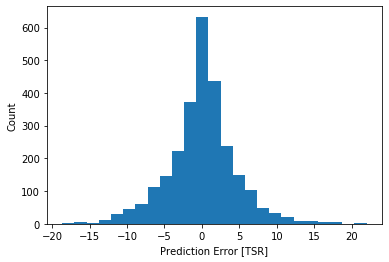

In [17]:
error = Y_test - Y_test_pred
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [TSR]")
_ = plt.ylabel("Count")

### Make TSR predictions using the full dataset

In [19]:
# test_predictions = model.predict(normed_test_data).flatten()
y_pred = best_model.predict(x).flatten()

### Ingest TSR predictions to PG

In [20]:
pergrid_all_predicted = pd.DataFrame(
    {'grid_id': grid_id,
     'tsr': y,
     'tsr_predicted': y_pred})

In [21]:
pergrid_all_predicted.head()

,grid_id,tsr,tsr_predicted
1,111,2.0,8.390343
4,338,1.0,8.116247
5,339,2.0,8.116247
6,340,2.0,8.116247
7,342,2.0,8.116247


In [190]:
pergrid_all_predicted.to_sql(name='m5_base_fnn', con=engine, schema='predictor', if_exists='replace', index=False)

In [191]:
update_geom = """
alter table predictor.m5_base_fnn add column if not exists wkb_geometry geometry(Polygon,4269);
update predictor.m5_base_fnn A SET wkb_geometry = B.wkb_geometry
FROM predictor.pergrid_base B
WHERE A.grid_id = B.grid_id
"""

In [192]:
connection = engine.connect()
connection.execute(update_geom)

In [193]:
update_residual = """
alter table predictor.m5_base_fnn add column residual double precision;
update predictor.m5_base_fnn set residual = (tsr_predicted-tsr);
"""

In [194]:
connection = engine.connect()
connection.execute(update_residual)